In [1]:
import abc
import time
import typing
import warnings

import tqdm
import torch
import wandb
import random
import pandas
import torchscan
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [2]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

# 1. Train the CNN based classifier

## Load the dataset


In [3]:
fix_random()

# Transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean = torch.tensor([ 0.491, 0.482, 0.447 ]),
        std = torch.tensor([ 0.247, 0.244, 0.262 ])
    )
])

# Load dataset
train_set = torchvision.datasets.CIFAR10('cifar-10', train = True, download = True, transform = transforms)
test_set = torchvision.datasets.CIFAR10('cifar-10', train = False, download = True, transform = transforms)

# Split train dataset into train and val
train_set, val_set = torchdata.random_split(train_set, [ len(train_set) - 5000, 5000 ])

# Extract labels
labels = test_set.classes

# Check
print(len(train_set), len(val_set), len(test_set))
print(labels)

Files already downloaded and verified
Files already downloaded and verified
45000 5000 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


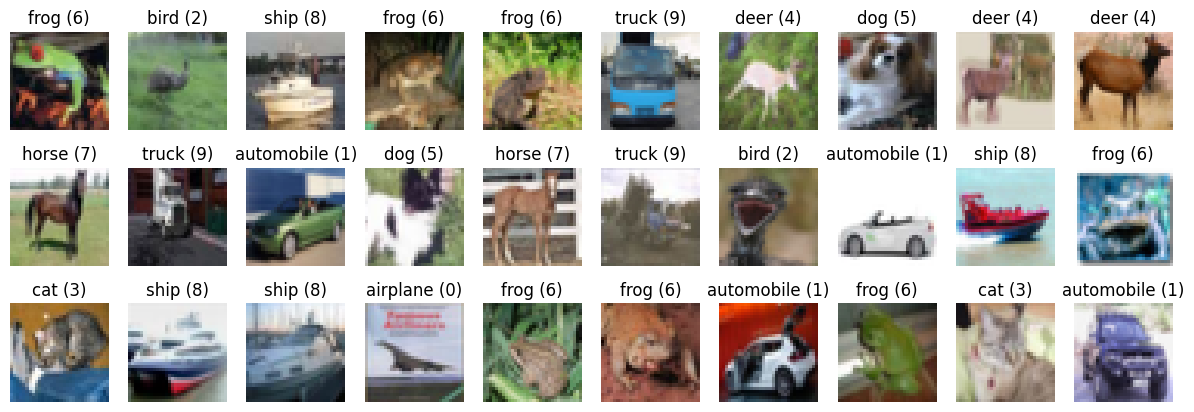

In [4]:
# Denormalization
denormalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1 / transforms.transforms[1].std
    ),
    torchvision.transforms.Normalize(
        mean = -transforms.transforms[1].mean,
        std = [ 1., 1., 1. ]
    )
])

# Display some samples from each dataset
plt.rcParams["figure.figsize"] = (15, 5)
for i in range(10):
    image, class_num = train_set[i]
    plt.subplot(3, 10, i + 1)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

for i in range(10):
    image, class_num = val_set[i]
    plt.subplot(3, 10, i + 11)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

for i in range(10):
    image, class_num = test_set[i]
    plt.subplot(3, 10, i + 21)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

## Function for accuracy checking

In [5]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, dataset: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset) -> dict:
        all_true = torch.tensor([])
        all_scores = torch.empty((0, 10))
        all_predictions = torch.tensor([])
        loader = torchdata.DataLoader(dataset, batch_size = 512, shuffle = False)
        for images, labels in loader:
            all_true = torch.cat([ all_true, labels ])
            predictions, scores = self.predict(images)
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        return {
            '': '',
            'Accuracy':       sklearn.metrics.accuracy_score      (all_true, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 2),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 3),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 4),
            'TOP-5 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 5),
            'TOP-6 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 6),
            'TOP-7 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 7),
            'TOP-8 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 8),
            'TOP-9 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 9),
            'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_true, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_true, all_predictions, average = 'macro'),
            'Recall':         sklearn.metrics.recall_score        (all_true, all_predictions, average = 'macro'),
            'F1-score':       sklearn.metrics.f1_score            (all_true, all_predictions, average = 'macro')
        }

## Implement CNN class for CIFAR10

In [6]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            device: torch.device = device,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.history = [ ]
        self.device = device
        self.input_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters())


    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images.to(self.device)) # Get predictions
        loss = torch.nn.functional.cross_entropy(output, labels.to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for images, labels in loader:
            sum_loss += self.train(images, labels) # Train on one batch
        if self.scheduler is not None:
            self.scheduler.step()
        return sum_loss / len(loader) # Return average loss to avoid random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 25):
        if self.input_shape is None:
            self.predict(train_set[0][0].unsqueeze(0)) # Initialize lazy layers and input shape
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)
        wandb.init(project = "CV-HW-4", name = self.name, anonymous = "allow")
        wandb.watch(self.model, log = "all")
        for epoch in tqdm.trange(n_epochs):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1
            self.history.append(metrics)

        # Finish the run
        wandb.finish()

        # Store best metrics
        best_metrics = max(self.history, key = lambda item: item['Accuracy'])
        Classifier.results.append({ **best_metrics, 'Name': self.name })

        return self
    

    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        if self.input_shape is None:
            self.input_shape = images[0].shape # Lazily initialize input shape
        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(images.to(self.device)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions
        return predictions, scores
    

    def summary(self):
        warnings.filterwarnings("ignore")
        display(pandas.DataFrame(Classifier.results).set_index("Name"))
        torchscan.summary(self.model.eval(), self.input_shape, receptive_field = True)

### Разный размер ядра

In [7]:
Classifier.results = [ ]
def test_kernel_size(kernel_size):
    fix_random()
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = kernel_size), torch.nn.GELU(),
        torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
        torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
    )
    Classifier('kernel_size = {}'.format(kernel_size), model).fit(train_set, val_set).summary()

In [8]:
test_kernel_size(3)

d:\Programs\Programming\Python\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


100%|██████████| 25/25 [03:16<00:00,  7.85s/it]


AUC-ROC,▁▅▆▇█████████████████████
Accuracy,▁▄▅▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████
F1-score,▁▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇███▇█████
Loss,█▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▅▅▆▇▇█▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇▇
Recall,▁▄▅▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█████
TOP-2 Accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇▇
TOP-3 Accuracy,▁▅▆▇▇▇▇█▇▇▇█▇█▇█▇███▇█▇▇▇
TOP-4 Accuracy,▁▄▆▆▇▇▇█▇▇▇▇█▇▆▇▇▇██▇▇▇▇▇
TOP-5 Accuracy,▁▅▆▇▇▇██▇██▇█▇▇█▇▇▇█▇▇▇▆▇
TOP-6 Accuracy,▁▃▆▆▆▆██▆▇█▇▆▆▇▆▆▆▆▆▆▆▅▅▅


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.626,0.8028,0.882,0.9302,0.9572,0.9742,0.9868,0.9922,0.997,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               3              
├─0                          Conv2d                (-1, 16, 30, 30)          448             3              
├─1                          GELU                  (-1, 16, 30, 30)          0               1              
├─2                          Flatten               (-1, 14400)               0               1              
├─3                          Dropout               (-1, 14400)               0               1              
├─4                          Linear                (-1, 1024)                14,746,624      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [9]:
test_kernel_size(5)

100%|██████████| 25/25 [03:02<00:00,  7.32s/it]


AUC-ROC,▁▄▅▇▇▆▇▇▇▇█▇▆▇██▇█████▇▇▇
Accuracy,▁▄▄▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇
F1-score,▁▄▄▆▆▆▆▇▆▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇
Loss,█▆▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▄▆▅▆▆▇▆▆▇▇▆▆▇▇▇▇▇▇▇█▇▇▆
Recall,▁▄▄▆▆▆▆▇▆▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇
TOP-2 Accuracy,▁▃▄▅▆▆▆▇▆▆▇▇▆▆▇▇▆▆▇█▇█▇▇▇
TOP-3 Accuracy,▁▄▄▇▇▆▆▇▇▇▇▆▆▇▇▇▇█████▇▇█
TOP-4 Accuracy,▁▃▄▆▆▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇█
TOP-5 Accuracy,▁▄▃▇▆▆▇▆▇▇▇█▆█▇▇▇▇▇▆▇▆▆▇▇
TOP-6 Accuracy,▁▃▁▇▅▄▅▅▆▆▇▆▃█▆▆▅▆▅▅▆▆▃▅▅


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               5              
├─0                          Conv2d                (-1, 16, 28, 28)          1,216           5              
├─1                          GELU                  (-1, 16, 28, 28)          0               1              
├─2                          Flatten               (-1, 12544)               0               1              
├─3                          Dropout               (-1, 12544)               0               1              
├─4                          Linear                (-1, 1024)                12,846,080      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [10]:
test_kernel_size(7)

100%|██████████| 25/25 [02:57<00:00,  7.09s/it]


AUC-ROC,▁▄▆▇▇▇▇▇▇▇▇████▇█▇█████▇▇
Accuracy,▁▄▅▆▆▇▅▆▇▇▇█▇▇▇▇█▇▇██▇█▇▇
F1-score,▁▄▅▆▆▇▆▆▇▇▇█▇█▇▇█▇▇██▇██▇
Loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▅▆▆▇▆▆▇▇▇█▇▇▇▇█▇▇██▇██▇
Recall,▁▄▅▆▆▇▅▆▇▇▇█▇▇▇▇█▇▇██▇█▇▇
TOP-2 Accuracy,▁▄▅▆▆▇▆▇▇▇▇███▇▇▇▇█▇█▇█▇▇
TOP-3 Accuracy,▁▄▆▆▇▇▇▇▇▇▇███▇▇▇▇▇▇███▇▇
TOP-4 Accuracy,▁▄▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇
TOP-5 Accuracy,▁▅▆▆▇▇▇█▇▇▇▆▇▇▆▇█▆▇▇▇▇▇▇▇
TOP-6 Accuracy,▁▄▆▆▇▆▇▇▇▇▆▅▆▆▅█▇▅▆▆▇▆▆█▅


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 26, 26)          2,368           7              
├─1                          GELU                  (-1, 16, 26, 26)          0               1              
├─2                          Flatten               (-1, 10816)               0               1              
├─3                          Dropout               (-1, 10816)               0               1              
├─4                          Linear                (-1, 1024)                11,076,608      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [11]:
test_kernel_size(11)

100%|██████████| 25/25 [02:58<00:00,  7.14s/it]


AUC-ROC,▁▄▄▆▇▇█▇██▇█▇████▇██████▇
Accuracy,▁▄▄▅▆▇▇▇▇█▇█▇████▇▇▇█▇▇▇▇
F1-score,▁▄▄▅▆▇▇▇▇▇██▇████▇▇██▇▇▇▇
Loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Precision,▁▄▄▆▆▇▇▇▇███▇████▇▇▇█▇▇▇▇
Recall,▁▄▄▅▆▇▇▇▇█▇█▇█████▇▇█▇▇▇▇
TOP-2 Accuracy,▁▄▅▅▇▇▇▇▇▇▇▇▇████▇▇▇█▇█▇▇
TOP-3 Accuracy,▁▄▅▅▆▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇██▇▆
TOP-4 Accuracy,▁▄▄▄▇▇▆▇█▇▇▇▆█▆█▇▇▇▇██▇▇▇
TOP-5 Accuracy,▁▃▅▄▆▇▇▆▇▆▇▆▅▇▆▇▇▆▇▆██▇▇▇
TOP-6 Accuracy,▁▄▆▆▇▇▇▇▆▅▆▆▃█▆▇▆▆▇▆▇▇█▇█


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               11             
├─0                          Conv2d                (-1, 16, 22, 22)          5,824           11             
├─1                          GELU                  (-1, 16, 22, 22)          0               1              
├─2                          Flatten               (-1, 7744)                0               1              
├─3                          Dropout               (-1, 7744)                0               1              
├─4                          Linear                (-1, 1024)                7,930,880       1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [12]:
test_kernel_size(17)

100%|██████████| 25/25 [03:04<00:00,  7.40s/it]


AUC-ROC,▁▄▅▆▇▇▇▇█▇▇██▇███████▇▇█▇
Accuracy,▁▃▅▆▆▇▇▇▇▇█▇██████▇██▇███
F1-score,▁▄▅▆▇▆▇▇▇▇█▇██████▇██▇███
Loss,█▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Precision,▁▄▅▆▇▇▇▇▇▇█▇██████▇██████
Recall,▁▄▅▆▆▇▇▇▇▇████████▇██▇███
TOP-2 Accuracy,▁▄▄▆▆▆▇▆▇▇▇▇█▇█▇████▇▇▇█▇
TOP-3 Accuracy,▁▄▄▄▆▆▇▆▇▆▇▇▇▆▇▇▇████▇▇█▇
TOP-4 Accuracy,▁▄▄▅▅▆▇▇▇▆▇▇▇▇▇█▇█▇█▇▇▇█▇
TOP-5 Accuracy,▁▃▃▄▄▆▇▆▇▇▇▇▇█▇▇██▆▇▆▆▇▇▇
TOP-6 Accuracy,▁▃▃▅▅▅▇▆▇▆▆▇▇█▆▇▇▇▆▆▇▆▆▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12
kernel_size = 17,,0.5948,0.7760,0.8658,0.9168,0.9470,0.9694,0.9826,0.9916,0.9966,0.915093,0.591644,0.593349,0.591811,0.709659,6.630951,0.699018,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               17             
├─0                          Conv2d                (-1, 16, 16, 16)          13,888          17             
├─1                          GELU                  (-1, 16, 16, 16)          0               1              
├─2                          Flatten               (-1, 4096)                0               1              
├─3                          Dropout               (-1, 4096)                0               1              
├─4                          Linear                (-1, 1024)                4,195,328       1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

![Alternative Text][1697989912242]

[1697989912242]: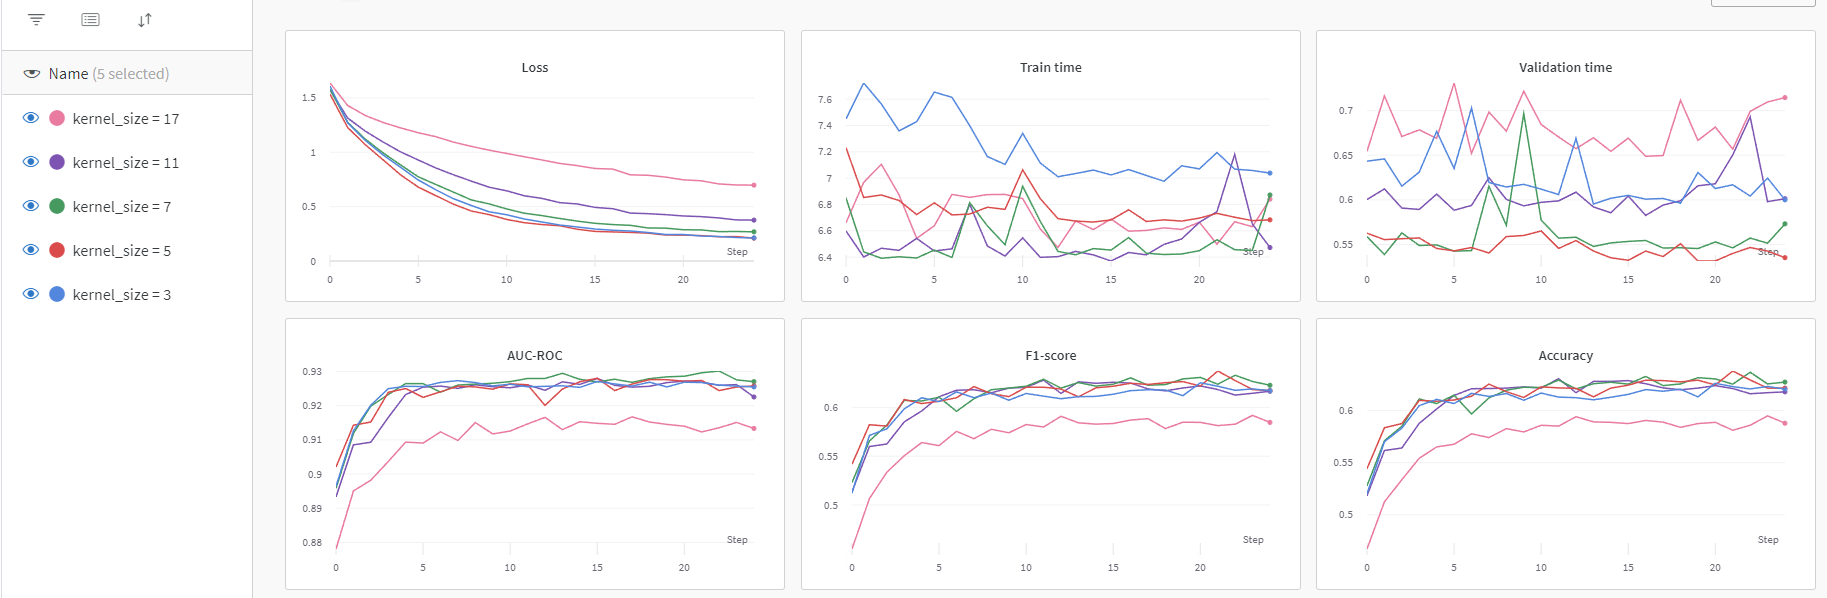

Видно, что при размере ядра 5 и 7 качество выше, чем при размере ядра 3. Тем не менеее дальнейшее увеличение фильтров ведёт к уменьшению качества. \
Вероятно, это связано с тем, что свёрточный слой уменьшает размер картинки, и при использовании больших ядер в полносвязный слой передается слишком мало признаков, из-за чего модель недообучается.

### Padding
Проведём аналогичный эксперимент, но с использованием "padding". При этом при свертках не будет происходить уменьшение размера картинки

In [13]:
def test_kernel_size_with_padding(kernel_size):
    fix_random()
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = kernel_size, padding = kernel_size // 2), torch.nn.GELU(),
        torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
        torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
    )
    Classifier('kernel_size = {}, padding = {}'.format(kernel_size, kernel_size // 2), model).fit(train_set, val_set).summary()

In [14]:
test_kernel_size_with_padding(3)

100%|██████████| 25/25 [03:37<00:00,  8.68s/it]


AUC-ROC,▁▄▆▇████████▇▇█████▇██▇██
Accuracy,▁▃▅▆▇▇▆▇▇▇▇▇▇▆▇▇▇██▇████▇
F1-score,▁▃▅▆▇▇▆▇▇▇▇▇▇▇█▇████████▇
Loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▅▆▇▇▇▇▇▇▇▇▇▇█▇████████▇
Recall,▁▃▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇██▇████▇
TOP-2 Accuracy,▁▃▆▇▇▇▇▇▇█▇▇▇▇▇██████▇▇██
TOP-3 Accuracy,▁▃▅▇▇▇▆▇▆█▇▇▇▇▇▇█▇▇▇▇▇▇██
TOP-4 Accuracy,▁▃▆▇▇▇▆▆▆▇▇▇▇▇█▇█▇▇▆▇▇▇▇▇
TOP-5 Accuracy,▁▃▅▇▇▇▆█▆▇▇▇▆▇█▇█▇▇▆▇▇▆▆▇
TOP-6 Accuracy,▁▂▆▇█▇▇▇▇█▇█▇▇█▇▇█▇▆▆▇▆▆▅


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12
kernel_size = 17,,0.5948,0.7760,0.8658,0.9168,0.9470,0.9694,0.9826,0.9916,0.9966,0.915093,0.591644,0.593349,0.591811,0.709659,6.630951,0.699018,24
"kernel_size = 3, padding = 1",,0.6292,0.7990,0.8826,0.9282,0.9588,0.9770,0.9860,0.9928,0.9970,0.925823,0.626447,0.628380,0.626317,0.634415,7.626509,0.274368,19


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               3              
├─0                          Conv2d                (-1, 16, 32, 32)          448             3              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [15]:
test_kernel_size_with_padding(5)

100%|██████████| 25/25 [03:36<00:00,  8.67s/it]


AUC-ROC,▁▄▅▇▇▇█▇▇▇███▇████▇█▇▇██▇
Accuracy,▁▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
F1-score,▁▄▄▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██
Loss,█▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▄▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██
Recall,▁▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
TOP-2 Accuracy,▁▃▄▆▇▆▇▇▇▇██▇▇██████▇▇▇█▇
TOP-3 Accuracy,▁▄▅▆▇▆█▇▇██▇▇▇▇██▇▇█▇▆▇█▇
TOP-4 Accuracy,▁▄▅▇▇▇▇████▇▇▇███▇█▆▇▇▇▇▇
TOP-5 Accuracy,▁▄▅▇▇▇▇███▇▇▇▅▇▇▇▆▇▇▆▆▆▇▇
TOP-6 Accuracy,▁▄▅█▆▇▇▆▆▇▆▆▆▄▆▇▆▆▆▆▅▆▇▆▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12
kernel_size = 17,,0.5948,0.7760,0.8658,0.9168,0.9470,0.9694,0.9826,0.9916,0.9966,0.915093,0.591644,0.593349,0.591811,0.709659,6.630951,0.699018,24
"kernel_size = 3, padding = 1",,0.6292,0.7990,0.8826,0.9282,0.9588,0.9770,0.9860,0.9928,0.9970,0.925823,0.626447,0.628380,0.626317,0.634415,7.626509,0.274368,19
"kernel_size = 5, padding = 2",,0.6332,0.7992,0.8810,0.9254,0.9572,0.9762,0.9862,0.9942,0.9976,0.927112,0.633803,0.632042,0.632322,0.661940,7.751741,0.205363,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               5              
├─0                          Conv2d                (-1, 16, 32, 32)          1,216           5              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [16]:
test_kernel_size_with_padding(7)

100%|██████████| 25/25 [03:48<00:00,  9.14s/it]


AUC-ROC,▁▄▅▇▇▇▇█▇▇█▇██▇█████▇▇█▇█
Accuracy,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
F1-score,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
Loss,█▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▄▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█
Recall,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
TOP-2 Accuracy,▁▄▄▆▇▇▇▇▇▇▇▇██▇▇▇▇█▇█▇▇▇█
TOP-3 Accuracy,▁▃▄▆▇▆▇▇▇▇▇▇▇█▆▇▇▇▇▇▇▆▇▇█
TOP-4 Accuracy,▁▃▅▅▇▆▇▆▆▆▇▇▇█▆▇▇▇▇▇▆▇▆▆█
TOP-5 Accuracy,▁▅▆▇▇██▇▇▆▇▇▇████▇▇▇▆▇▇▇█
TOP-6 Accuracy,▁▄▅▆▇█▆▅▇▄▆▇▆▇▇▇▇▆▅▆▄▆▆▅▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12
kernel_size = 17,,0.5948,0.7760,0.8658,0.9168,0.9470,0.9694,0.9826,0.9916,0.9966,0.915093,0.591644,0.593349,0.591811,0.709659,6.630951,0.699018,24
"kernel_size = 3, padding = 1",,0.6292,0.7990,0.8826,0.9282,0.9588,0.9770,0.9860,0.9928,0.9970,0.925823,0.626447,0.628380,0.626317,0.634415,7.626509,0.274368,19
"kernel_size = 5, padding = 2",,0.6332,0.7992,0.8810,0.9254,0.9572,0.9762,0.9862,0.9942,0.9976,0.927112,0.633803,0.632042,0.632322,0.661940,7.751741,0.205363,24
"kernel_size = 7, padding = 3",,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.664009,8.265993,0.224136,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [17]:
test_kernel_size_with_padding(11)

100%|██████████| 25/25 [03:56<00:00,  9.46s/it]


AUC-ROC,▁▃▅▆▇▇█▇█▇▇█████▇▇▇▅▇▇▇▇█
Accuracy,▁▃▄▅▆▇▇▇▇▇██▇▇███▇▇▇██▇█▇
F1-score,▁▂▅▅▆▇▇▇▇▇██▇▇███▇▇▇██▇██
Loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▅▆▆▇▇▇▇▇██▇▇███▇▇▇█████
Recall,▁▃▄▅▆▇▇▇▇▇██▇▇███▇▇▇██▇██
TOP-2 Accuracy,▁▃▄▆▇▇▇▇▇▇▇█▇██▇██▇▆██▇▇█
TOP-3 Accuracy,▁▂▄▅▅▇▇▇▇▇▇█▇▇█▇▇█▇▆▇▇▇▆▇
TOP-4 Accuracy,▁▃▅▆▆▇█▇▇▇▆█▆█▇▇▇▇▆▆▇▆▇▇▇
TOP-5 Accuracy,▁▂▅▆▇▆█▇▇▆▇▇▄▇▇▇▅▅▅▆▆▅▅▆█
TOP-6 Accuracy,▁▁▆▇▇▆█▆▆▆▆▇▅█▆▆▅▅▅▅▆▅▇▅▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12
kernel_size = 17,,0.5948,0.7760,0.8658,0.9168,0.9470,0.9694,0.9826,0.9916,0.9966,0.915093,0.591644,0.593349,0.591811,0.709659,6.630951,0.699018,24
"kernel_size = 3, padding = 1",,0.6292,0.7990,0.8826,0.9282,0.9588,0.9770,0.9860,0.9928,0.9970,0.925823,0.626447,0.628380,0.626317,0.634415,7.626509,0.274368,19
"kernel_size = 5, padding = 2",,0.6332,0.7992,0.8810,0.9254,0.9572,0.9762,0.9862,0.9942,0.9976,0.927112,0.633803,0.632042,0.632322,0.661940,7.751741,0.205363,24
"kernel_size = 7, padding = 3",,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.664009,8.265993,0.224136,25
"kernel_size = 11, padding = 5",,0.6334,0.7918,0.8764,0.9272,0.9562,0.9734,0.9882,0.9934,0.9972,0.925879,0.631310,0.632207,0.630726,0.665652,8.574581,0.269307,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               11             
├─0                          Conv2d                (-1, 16, 32, 32)          5,824           11             
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [18]:
test_kernel_size_with_padding(17)

100%|██████████| 25/25 [06:20<00:00, 15.20s/it]


AUC-ROC,▁▄▄▆▇▇▇▇████▇▆█▇▇█▇█▇▇▇▇▇
Accuracy,▁▃▄▅▇▅▆▆▇▇▇▇▇▇▇▇▇█▇█▇████
F1-score,▁▄▄▅▇▆▆▆▇▇▇▇▇▇█▇▇█▇██████
Loss,█▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▄▄▅▆▅▆▆▇▇▇▇▆▆▇▇▇▇▇█▇████
Recall,▁▃▄▅▇▅▆▆▇▇▇▇▇▇▇▇▇█▇█▇████
TOP-2 Accuracy,▁▄▄▅▇▆▆▆▇██▇▇▆█▇▇█▇█▇▇▇▇▇
TOP-3 Accuracy,▁▅▄▅▆▆▇▆▇██▇▇▆█▇▇█▇▇▇▇█▆▇
TOP-4 Accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▆█▇▇█▇▇▆██▇▆
TOP-5 Accuracy,▁▄▄▆▅▅▇▆▇▇█▇▇▅█▇▆▇▆▇▅▆▇▇▆
TOP-6 Accuracy,▁▃▃▇▆▄▇█▇▇▆▇▆▅▇▇▆▇▆▆▅▆▆▅▅


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
kernel_size = 3,,0.6260,0.8028,0.8820,0.9302,0.9572,0.9742,0.9868,0.9922,0.9970,0.926867,0.626609,0.625152,0.625129,0.612691,7.069847,0.242987,21
kernel_size = 5,,0.6378,0.8068,0.8836,0.9286,0.9586,0.9768,0.9874,0.9928,0.9974,0.927365,0.639484,0.636993,0.637248,0.540058,6.732120,0.233504,22
kernel_size = 7,,0.6366,0.8052,0.8846,0.9306,0.9584,0.9746,0.9868,0.9932,0.9974,0.930131,0.632556,0.635517,0.632905,0.557177,6.456272,0.269893,23
kernel_size = 11,,0.6304,0.7920,0.8732,0.9260,0.9542,0.9740,0.9856,0.9930,0.9962,0.926063,0.630225,0.628519,0.627918,0.598856,6.398234,0.599746,12
kernel_size = 17,,0.5948,0.7760,0.8658,0.9168,0.9470,0.9694,0.9826,0.9916,0.9966,0.915093,0.591644,0.593349,0.591811,0.709659,6.630951,0.699018,24
"kernel_size = 3, padding = 1",,0.6292,0.7990,0.8826,0.9282,0.9588,0.9770,0.9860,0.9928,0.9970,0.925823,0.626447,0.628380,0.626317,0.634415,7.626509,0.274368,19
"kernel_size = 5, padding = 2",,0.6332,0.7992,0.8810,0.9254,0.9572,0.9762,0.9862,0.9942,0.9976,0.927112,0.633803,0.632042,0.632322,0.661940,7.751741,0.205363,24
"kernel_size = 7, padding = 3",,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.664009,8.265993,0.224136,25
"kernel_size = 11, padding = 5",,0.6334,0.7918,0.8764,0.9272,0.9562,0.9734,0.9882,0.9934,0.9972,0.925879,0.631310,0.632207,0.630726,0.665652,8.574581,0.269307,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               17             
├─0                          Conv2d                (-1, 16, 32, 32)          13,888          17             
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

![Alternative Text][1697989761324]

[1697989761324]: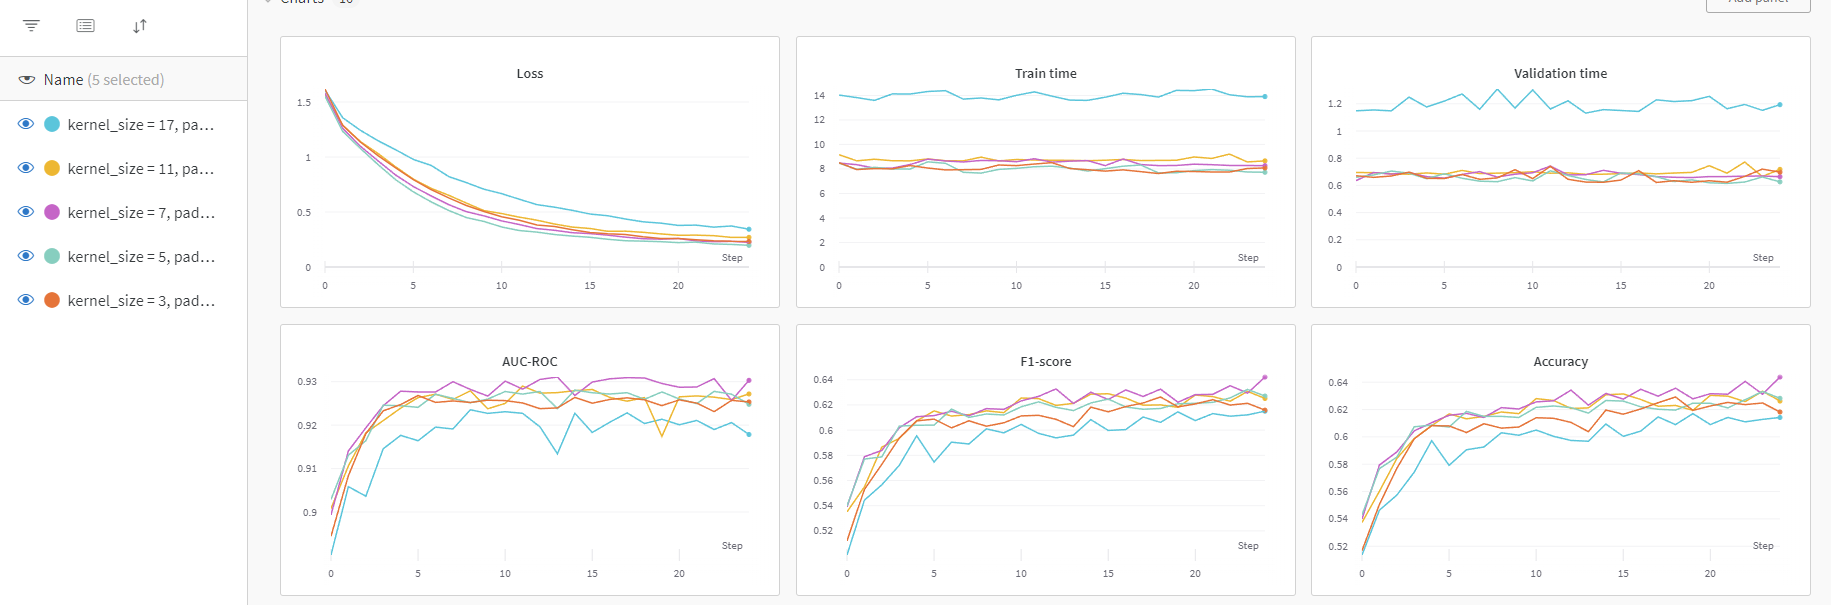

Использование отступа привело к повышению качества. Тем не менее большие свёртки (11, 17) всё равно показывают себя хуже, чем маленькие (5, 7). Для дальнейших экспериментов будем использовать фильтры размера 7, так как модель с этим размером свертки достигла наибольшего качества 

### Различный тип паддинга

In [19]:
Classifier.results = [ ]
def test_padding_mode(padding_mode):
    fix_random()
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3, padding_mode = padding_mode), torch.nn.GELU(),
        torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
        torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
    )
    Classifier('padding_mode = {}'.format(padding_mode), model).fit(train_set, val_set).summary()

In [20]:
test_padding_mode('zeros')

100%|██████████| 25/25 [03:48<00:00,  9.14s/it]


AUC-ROC,▁▄▅▇▇▇▇█▇▇█▇██▇█████▇▇█▇█
Accuracy,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
F1-score,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
Loss,█▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▄▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█
Recall,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
TOP-2 Accuracy,▁▄▄▆▇▇▇▇▇▇▇▇██▇▇▇▇█▇█▇▇▇█
TOP-3 Accuracy,▁▃▄▆▇▆▇▇▇▇▇▇▇█▆▇▇▇▇▇▇▆▇▇█
TOP-4 Accuracy,▁▃▅▅▇▆▇▆▆▆▇▇▇█▆▇▇▇▇▇▆▇▆▆█
TOP-5 Accuracy,▁▅▆▇▇██▇▇▆▇▇▇████▇▇▇▆▇▇▇█
TOP-6 Accuracy,▁▄▅▆▇█▆▅▇▄▆▇▆▇▇▇▇▆▅▆▄▆▆▅▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
padding_mode = zeros,,0.6438,0.81,0.8914,0.9382,0.962,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.706578,8.175859,0.224136,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [21]:
test_padding_mode('reflect')

100%|██████████| 25/25 [03:41<00:00,  8.87s/it]


AUC-ROC,▁▄▆▇▇█▇████▇███████████▇▇
Accuracy,▁▄▅▆▇▇▆▆█▇▇▇▇▇▇██▇▇████▇█
F1-score,▁▄▅▆▇▆▆▇█▇▇▇▇▇▇▇█▇▇████▇▇
Loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▅▆▇▆▆▇█▇▇▇▇▇▇▇█▇▇█████▇
Recall,▁▃▅▆▇▇▆▇█▇▇▇▇▇▇██▇▇████▇█
TOP-2 Accuracy,▁▄▆▇▇▇▇▇▇▇▇█▇▇▇▇█████▇██▇
TOP-3 Accuracy,▁▅▅▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇███▆
TOP-4 Accuracy,▁▄▄▅█▇▇▇▇▇▆▇██▇▇█▇▇▆▆██▇▆
TOP-5 Accuracy,▁▅▅▆██▇▆▇██▆▆▅▇▇▆▆▆▇▅▇▇▆▆
TOP-6 Accuracy,▁▅▅▇█▇▆▆▇█▇▇▆▅▆▅▅▆▆▇▅▆▇▆▅


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
padding_mode = zeros,,0.6438,0.8100,0.8914,0.9382,0.962,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.706578,8.175859,0.224136,25
padding_mode = reflect,,0.6314,0.8038,0.8818,0.9290,0.955,0.9732,0.9862,0.9926,0.9974,0.926995,0.629485,0.630388,0.629366,0.691856,8.372394,0.289257,17


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [22]:
test_padding_mode('replicate')

100%|██████████| 25/25 [03:56<00:00,  9.46s/it]


AUC-ROC,▁▄▆▇▆▇▇▇▇▇▇▇▇▇▇██████▇▇█▇
Accuracy,▁▄▅▆▆▆▇▇▆▇▇▇▇▇▇█▇▇███▇▇▇▇
F1-score,▁▄▅▆▆▆▇▇▆▇▇▇▇▇▇████▇█▇▇▇▇
Loss,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▅▆▆▆▇▇▆▇▇▇▇▇▇▇█████▇▇█▇
Recall,▁▄▅▆▆▆▇▇▆▇▇▇▇▇▇█▇████▇▇▇▇
TOP-2 Accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇████▇█▇▇▇▇
TOP-3 Accuracy,▁▄▅▇▆▇▇▇▇▇▇██▇▇████▇█▇██▇
TOP-4 Accuracy,▁▅▆▆▆▇▇▆▇▆▇█▇▆▆▇▇▇█▇▇▇▇█▇
TOP-5 Accuracy,▁▄▆▇▇▇▇▇▆▆▇▇▇▆▆▆▇▇█▇▆▇▇█▆
TOP-6 Accuracy,▁▄█▅▆▇▇▆▆▆▇▇▆▅▇▇█▇▇█▇▇▇▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
padding_mode = zeros,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.706578,8.175859,0.224136,25
padding_mode = reflect,,0.6314,0.8038,0.8818,0.9290,0.9550,0.9732,0.9862,0.9926,0.9974,0.926995,0.629485,0.630388,0.629366,0.691856,8.372394,0.289257,17
padding_mode = replicate,,0.6342,0.8066,0.8812,0.9304,0.9616,0.9774,0.9868,0.9930,0.9970,0.928661,0.631072,0.632993,0.631474,0.916442,8.704919,0.261026,19


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [23]:
test_padding_mode('circular')

100%|██████████| 25/25 [04:01<00:00,  9.64s/it]


AUC-ROC,▁▄▅▇▇▇▇▇█▇▇▇██▇▇▇▇▇▇▇▇██▇
Accuracy,▁▃▄▅▅▆▆▆▇▆▇▆▇▇▇▇▇█▇▇▇▇██▇
F1-score,▁▃▄▅▅▅▇▆▇▆▇▆▇▇▇▇██▇▇▇▇██▇
Loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇█▇▇▇▇██▇
Recall,▁▃▄▅▅▅▆▆▇▆▇▆▇▇▇▇▇█▇▇▇▇██▇
TOP-2 Accuracy,▁▃▄▆▆▆▆█▇▇▇▇▇█▇█▇▇▇▇▇▇▇█▇
TOP-3 Accuracy,▁▃▅▇▇▇▆█▇▆▇▇▇█▇▇▇▆▇▇▇▆▇▇▆
TOP-4 Accuracy,▁▄▄▇█▇▇▇▆▇▇▇▇█▇▆▇▇▇▇▆▆▆▇▆
TOP-5 Accuracy,▁▅▅▇██▇██▇█▇▇▇▇█▇▇▇▇▆▆▆▇▆
TOP-6 Accuracy,▁▄▃▆▇█▆▇▇▇▇▆▇▆▅▇▅▆▇▅▇▇▆█▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
padding_mode = zeros,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.706578,8.175859,0.224136,25
padding_mode = reflect,,0.6314,0.8038,0.8818,0.9290,0.9550,0.9732,0.9862,0.9926,0.9974,0.926995,0.629485,0.630388,0.629366,0.691856,8.372394,0.289257,17
padding_mode = replicate,,0.6342,0.8066,0.8812,0.9304,0.9616,0.9774,0.9868,0.9930,0.9970,0.928661,0.631072,0.632993,0.631474,0.916442,8.704919,0.261026,19
padding_mode = circular,,0.6308,0.7956,0.8798,0.9248,0.9532,0.9754,0.9858,0.9916,0.9974,0.927403,0.628273,0.629326,0.627670,0.667910,9.828718,0.229444,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

![Alternative Text][1697989984683]

[1697989984683]: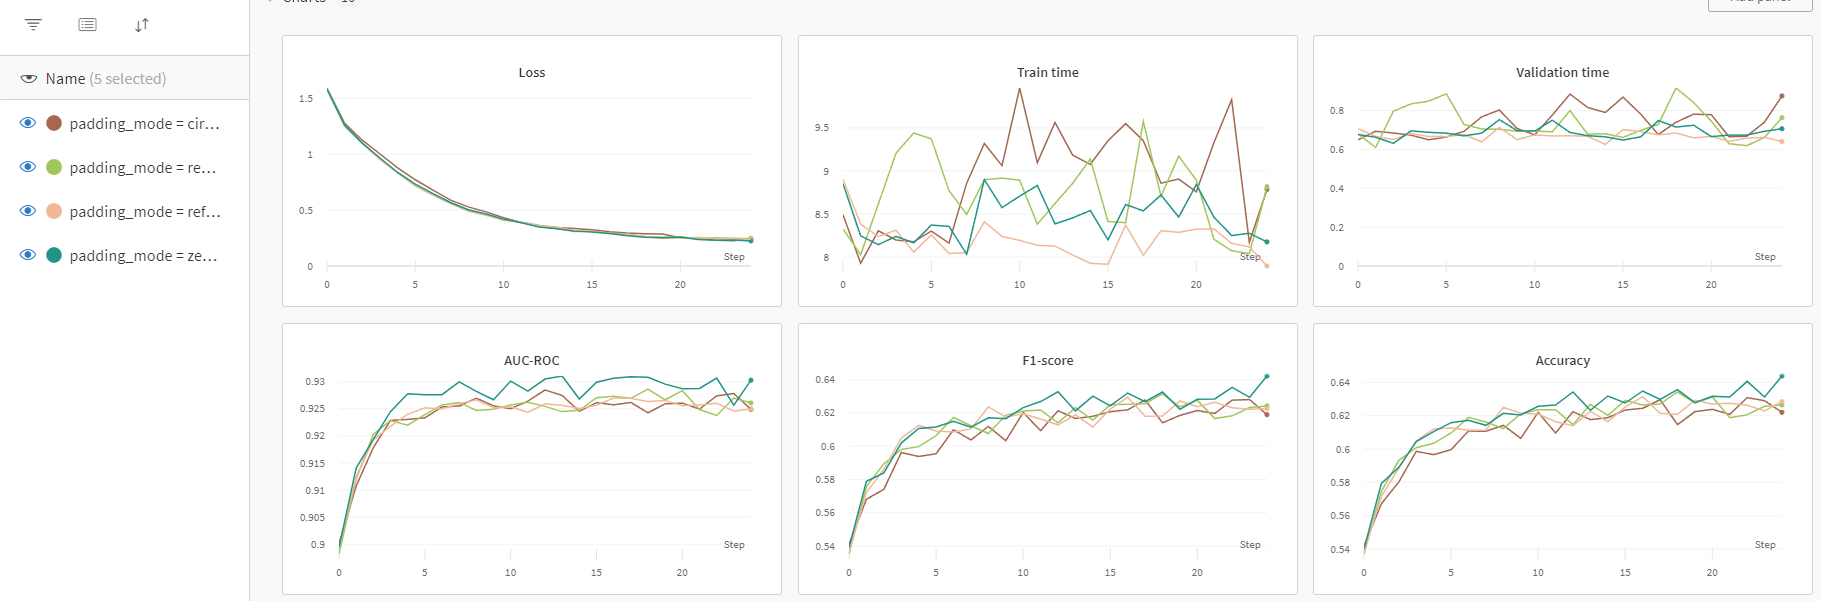

Таким образом, способ заполнения padding не оказывает сильного влияния на качество модели. Далее будем использовать стандартное значение - заполнение нулями (zeros)

### Количество фильтров

In [24]:
Classifier.results = [ ]
def test_out_channels(out_channels):
    fix_random()
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 3, out_channels = out_channels, kernel_size = 7, padding = 3), torch.nn.GELU(),
        torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
        torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
    )
    Classifier('out_channels = {}'.format(out_channels), model).fit(train_set, val_set).summary()

In [25]:
test_out_channels(8)

100%|██████████| 25/25 [03:23<00:00,  8.12s/it]


AUC-ROC,▁▅▇▇▇██▇█████▇████▇▇▇█▇▇▇
Accuracy,▁▄▆▆▆▇▇▇▇▇█▇█▇██▇██▇██▇██
F1-score,▁▄▆▆▆▇▇▇▇▇▇▇█▇██▇████████
Loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Precision,▁▄▆▇▇▇▇▇▇▇▇▇█▇██▇████████
Recall,▁▄▆▆▆▇▇▇▇▇█▇█▇██▇██▇█████
TOP-2 Accuracy,▁▄▅▆▆▇▇▇▇▇▇▇█▇▇█▇██▇█████
TOP-3 Accuracy,▁▅▆▇▇▇█▆▇▇▇█▇▇▇████▇▇▇▇█▇
TOP-4 Accuracy,▁▅▆▇▇█▇▇▇▇▇█▇▇▇▇███▇▇█▇██
TOP-5 Accuracy,▁▅▆▇▆▇▇▆█▇▇█▆▆▇▇█▇▆▇▇▇▇▇▆
TOP-6 Accuracy,▁▅▅▇▆▆▇▆▇▇▆▆▆▆▇█▇▅▆▅▆▇█▇▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
out_channels = 8,,0.6266,0.799,0.8826,0.9294,0.9564,0.9754,0.9864,0.9918,0.997,0.92414,0.625125,0.625614,0.623938,0.551776,6.242215,0.337497,19


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 8, 32, 32)           1,184           7              
├─1                          GELU                  (-1, 8, 32, 32)           0               1              
├─2                          Flatten               (-1, 8192)                0               1              
├─3                          Dropout               (-1, 8192)                0               1              
├─4                          Linear                (-1, 1024)                8,389,632       1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [26]:
test_out_channels(16)

100%|██████████| 25/25 [03:47<00:00,  9.10s/it]


AUC-ROC,▁▄▅▇▇▇▇█▇▇█▇██▇█████▇▇█▇█
Accuracy,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
F1-score,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
Loss,█▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▄▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█
Recall,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
TOP-2 Accuracy,▁▄▄▆▇▇▇▇▇▇▇▇██▇▇▇▇█▇█▇▇▇█
TOP-3 Accuracy,▁▃▄▆▇▆▇▇▇▇▇▇▇█▆▇▇▇▇▇▇▆▇▇█
TOP-4 Accuracy,▁▃▅▅▇▆▇▆▆▆▇▇▇█▆▇▇▇▇▇▆▇▆▆█
TOP-5 Accuracy,▁▅▆▇▇██▇▇▆▇▇▇████▇▇▇▆▇▇▇█
TOP-6 Accuracy,▁▄▅▆▇█▆▅▇▄▆▇▆▇▇▇▇▆▅▆▄▆▆▅▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
out_channels = 8,,0.6266,0.799,0.8826,0.9294,0.9564,0.9754,0.9864,0.9918,0.9970,0.924140,0.625125,0.625614,0.623938,0.551776,6.242215,0.337497,19
out_channels = 16,,0.6438,0.810,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.670155,8.409206,0.224136,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [27]:
test_out_channels(32)

100%|██████████| 25/25 [04:57<00:00, 11.91s/it]


AUC-ROC,▁▄▆▆▇▇▇▇▇▇▇▇▇█▇███▇▇▇█▇█▆
Accuracy,▁▃▅▅▆▇▆▇▆▇▇▇▇▇▇████▇██▇█▇
F1-score,▁▃▅▅▇▇▆▇▇▇▇▇▇█▇███████▇██
Loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▅▆▇▇▇▇▇▇▇▇▇█▇███████▇█▇
Recall,▁▃▅▅▆▇▆▇▆▇▇▇▇█▇████▇██▇█▇
TOP-2 Accuracy,▁▄▅▆▇▇▇▆▆▇▇▇▆▇▇▇▇███▇███▇
TOP-3 Accuracy,▁▄▅▆▇▇▆▇▇▆▇▇▆▇▇█▇█▇▇▇▇█▇▇
TOP-4 Accuracy,▁▄▅▅▆▇▇▇▇▇▇▆▆▇▇█▇█▆▇▆██▇▇
TOP-5 Accuracy,▁▄▅▅▇█▇▆▆█▇▆▆█▇██▇▆▇▅▇█▇▇
TOP-6 Accuracy,▁▄▆▆█▆▆▆▆▇▆▆▅▇▇██▅▆▇▅▆▇██


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
out_channels = 8,,0.6266,0.7990,0.8826,0.9294,0.9564,0.9754,0.9864,0.9918,0.9970,0.924140,0.625125,0.625614,0.623938,0.551776,6.242215,0.337497,19
out_channels = 16,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.670155,8.409206,0.224136,25
out_channels = 32,,0.6350,0.8034,0.8816,0.9282,0.9596,0.9784,0.9882,0.9928,0.9974,0.930088,0.630344,0.633473,0.631061,0.718652,11.802472,0.222715,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 32, 32, 32)          4,736           7              
├─1                          GELU                  (-1, 32, 32, 32)          0               1              
├─2                          Flatten               (-1, 32768)               0               1              
├─3                          Dropout               (-1, 32768)               0               1              
├─4                          Linear                (-1, 1024)                33,555,456      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [28]:
test_out_channels(64)

100%|██████████| 25/25 [07:57<00:00, 19.09s/it]


AUC-ROC,▁▄▅▆▇▇▇▇██▇▇███▇█▇██▇█▆▇█
Accuracy,▁▃▄▆▇▆▇▇▇█▇▇██▇█████▇█▇██
F1-score,▁▃▄▆▇▆▇▇▇█▇▇██▇█████▇█▇██
Loss,█▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▄▆▆▆▇▇▇█▆▇▇█▇█████▇█▇██
Recall,▁▃▄▆▇▆▇▇▇█▇▇██▇█████▇█▇██
TOP-2 Accuracy,▁▃▅▆▇▆▇▇█▇▇▇█████▇▇▇██▇▇█
TOP-3 Accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇██▇█▇▇▇▇█▇▇▇
TOP-4 Accuracy,▁▄▅▅▆▇▆▇▇▇▇▇███▇▇▇▇█▇▇▇█▇
TOP-5 Accuracy,▁▃▅▅▅▇▆▆▇▆▆▇█▇▇▆▇▇▆▇▆▇▆▇▇
TOP-6 Accuracy,▁▄▅▆▅▇▆▆▇█▆▇██▆▆▆▇▇▇▆▇▆▆▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
out_channels = 8,,0.6266,0.7990,0.8826,0.9294,0.9564,0.9754,0.9864,0.9918,0.9970,0.924140,0.625125,0.625614,0.623938,0.551776,6.242215,0.337497,19
out_channels = 16,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.670155,8.409206,0.224136,25
out_channels = 32,,0.6350,0.8034,0.8816,0.9282,0.9596,0.9784,0.9882,0.9928,0.9974,0.930088,0.630344,0.633473,0.631061,0.718652,11.802472,0.222715,24
out_channels = 64,,0.6332,0.7992,0.8782,0.9240,0.9542,0.9742,0.9860,0.9922,0.9972,0.927478,0.631337,0.632023,0.631091,0.811859,17.600344,0.307268,19


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 64, 32, 32)          9,472           7              
├─1                          GELU                  (-1, 64, 32, 32)          0               1              
├─2                          Flatten               (-1, 65536)               0               1              
├─3                          Dropout               (-1, 65536)               0               1              
├─4                          Linear                (-1, 1024)                67,109,888      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

![Alternative Text][1697990056571]

[1697990056571]: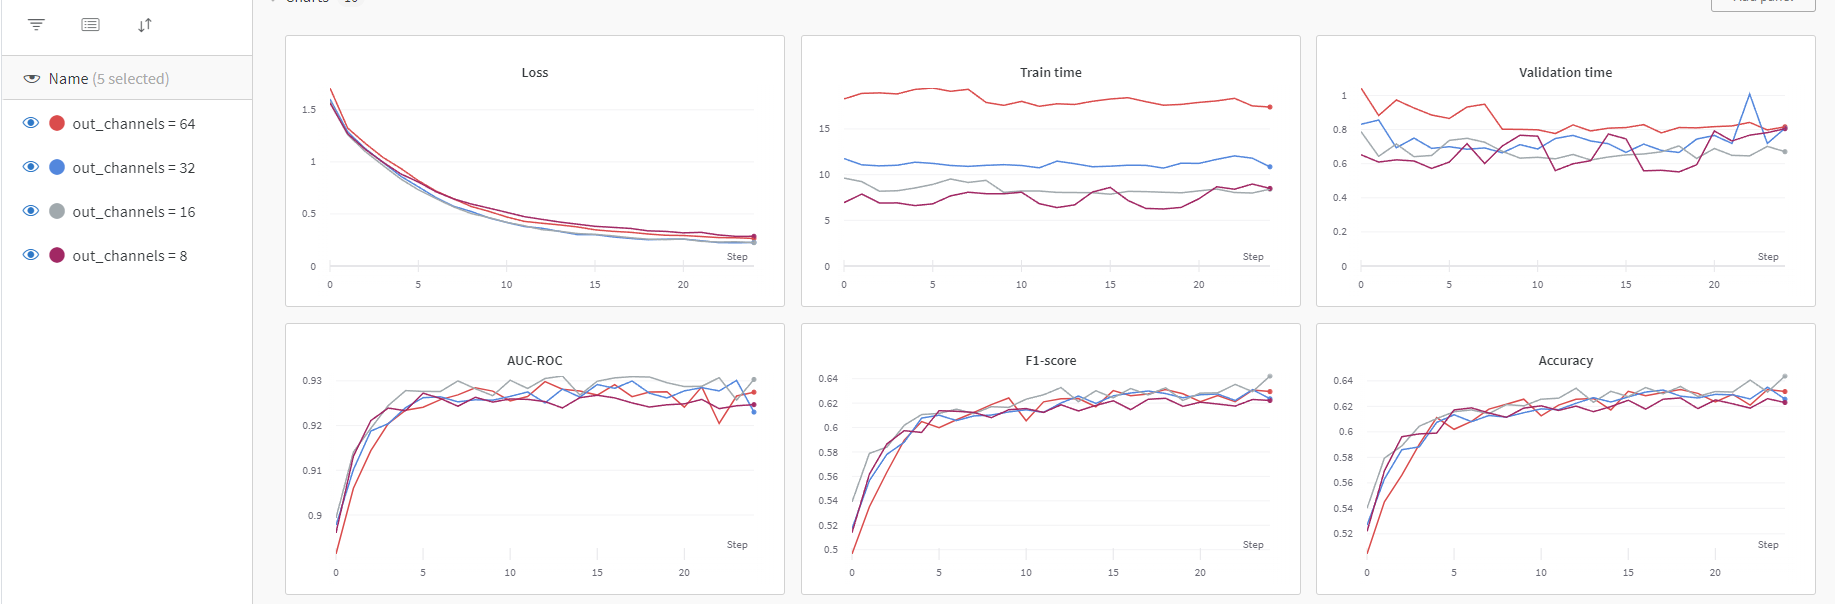

Количество фильтров также не сильно влияет на качество. Наибольшего значения целевой метрики достигла модель с 16 сверточными фильтрами, поэтому далее будем использовать ее.

### Количество свёрточных слоёв

In [29]:
Classifier.results = [ ]
def test_conv_amount(amount):
    fix_random()
    layers = [ ]
    for i in range(amount):
        layers.append(torch.nn.Conv2d(in_channels = (3 if i == 0 else 16), out_channels = 16, kernel_size = 7, padding = 3))
        layers.append(torch.nn.GELU())
    model = torch.nn.Sequential(
        *layers,
        torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
        torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
    )
    Classifier('{} convolutions'.format(amount), model).fit(train_set, val_set).summary()

In [30]:
test_conv_amount(1)

100%|██████████| 25/25 [03:39<00:00,  8.79s/it]


AUC-ROC,▁▄▅▇▇▇▇█▇▇█▇██▇█████▇▇█▇█
Accuracy,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
F1-score,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
Loss,█▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▄▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█
Recall,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█
TOP-2 Accuracy,▁▄▄▆▇▇▇▇▇▇▇▇██▇▇▇▇█▇█▇▇▇█
TOP-3 Accuracy,▁▃▄▆▇▆▇▇▇▇▇▇▇█▆▇▇▇▇▇▇▆▇▇█
TOP-4 Accuracy,▁▃▅▅▇▆▇▆▆▆▇▇▇█▆▇▇▇▇▇▆▇▆▆█
TOP-5 Accuracy,▁▅▆▇▇██▇▇▆▇▇▇████▇▇▇▆▇▇▇█
TOP-6 Accuracy,▁▄▅▆▇█▆▅▇▄▆▇▆▇▇▇▇▆▅▆▄▆▆▅▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 convolutions,,0.6438,0.81,0.8914,0.9382,0.962,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.697892,9.189537,0.224136,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               7              
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           7              
├─1                          GELU                  (-1, 16, 32, 32)          0               1              
├─2                          Flatten               (-1, 16384)               0               1              
├─3                          Dropout               (-1, 16384)               0               1              
├─4                          Linear                (-1, 1024)                16,778,240      1              
├─5                          GELU                  (-1, 1024)                0               1              
├─6                

In [31]:
test_conv_amount(2)

100%|██████████| 25/25 [04:21<00:00, 10.46s/it]


AUC-ROC,▁▅▆▇▇█████████████▇▇███▇▇
Accuracy,▁▄▆▆▆▇▇▇▇▇██▇█▇▇██▇▇▇▇▇▇▇
F1-score,▁▄▆▇▇▇▇▇▇▇██▇█▇▇██▇▇▇▇▇▇▇
Loss,█▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▅▇▇▇▇▇▇▇██▇▇▇▇██▇▇▇▇▇▇▇
Recall,▁▄▆▆▆▇▇▇▇▇██▇█▇▇██▇▇▇▇█▇▇
TOP-2 Accuracy,▁▄▆▇▆▇▇▇▇▇████▇▇▇█▇█▇█▇▇▇
TOP-3 Accuracy,▁▄▇▇▇▇▇█▇▇██▇█▇█████▇█▇▇▇
TOP-4 Accuracy,▁▅▆▇▆▇▇█▇█▇▇▇█▇▇▇▇▇▇▆▇▇▇▆
TOP-5 Accuracy,▁▅▇▇▇▇▇▇▇█▇█▇█▇▇▇▇▇▇▇█▇▇▇
TOP-6 Accuracy,▁▅▆▇▆█▇█▇█▇▇▆▇▇▆▇█▇▇▇▇▆▇▆


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 convolutions,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.697892,9.189537,0.224136,25
2 convolutions,,0.6838,0.8332,0.9070,0.9458,0.9684,0.9810,0.9904,0.9944,0.9984,0.945109,0.683458,0.683123,0.682162,0.850605,9.888809,0.181837,17


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               13             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           13             
├─1                          GELU                  (-1, 16, 32, 32)          0               7              
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          7              
├─3                          GELU                  (-1, 16, 32, 32)          0               1              
├─4                          Flatten               (-1, 16384)               0               1              
├─5                          Dropout               (-1, 16384)               0               1              
├─6                

In [32]:
test_conv_amount(3)

100%|██████████| 25/25 [04:58<00:00, 11.95s/it]


AUC-ROC,▁▄▇▇███▇█▇██████▇█████▇▇▇
Accuracy,▁▄▆▆▇▇▇▇▇▇██▇▇██▇█████▇▇█
F1-score,▁▄▆▇▇▇▇▇▇▇██▇▇██▇█████▇▇█
Loss,█▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▆▇▇▇▇▇▇▇██▇▇██▇█████▇██
Recall,▁▄▆▆▇▇▇▇▇▇██▇▇██▇▇████▇▇█
TOP-2 Accuracy,▁▄▆▇▇▇▇▇▇▇▇█▇▇██▇▇███▇▇▇▇
TOP-3 Accuracy,▁▄▆▇▇▇▇▇▇▇▇█▇▇▇█▇▇█▇▇▇▇▇▇
TOP-4 Accuracy,▁▅▇▇████▇▇▇█▇▇▇█▇▇█▇██▇▇▇
TOP-5 Accuracy,▁▅██████▇▇▇██▆██▇▇▇▇▇█▇▇▇
TOP-6 Accuracy,▁▅███▇▇▇▇▇▆▇█▆▇▇▆▇▇▇▇▇▇█▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 convolutions,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.697892,9.189537,0.224136,25
2 convolutions,,0.6838,0.8332,0.9070,0.9458,0.9684,0.9810,0.9904,0.9944,0.9984,0.945109,0.683458,0.683123,0.682162,0.850605,9.888809,0.181837,17
3 convolutions,,0.7178,0.8634,0.9200,0.9534,0.9714,0.9838,0.9918,0.9960,0.9984,0.955861,0.714049,0.717005,0.714595,0.786369,11.134442,0.145839,21


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               19             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           19             
├─1                          GELU                  (-1, 16, 32, 32)          0               13             
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          13             
├─3                          GELU                  (-1, 16, 32, 32)          0               7              
├─4                          Conv2d                (-1, 16, 32, 32)          12,560          7              
├─5                          GELU                  (-1, 16, 32, 32)          0               1              
├─6                

In [33]:
test_conv_amount(4)

100%|██████████| 25/25 [05:35<00:00, 13.44s/it]


AUC-ROC,▁▄▆▇▇███████████████▇████
Accuracy,▁▄▅▇▆█▇█████▇█▇██▇██▇████
F1-score,▁▄▆▇▆█▇█████████████▇████
Loss,█▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▆▇▇█▇█████████████▇████
Recall,▁▄▅▇▆█▇█████▇█▇█████▇████
TOP-2 Accuracy,▁▄▆▇▇█▇█████████████▇████
TOP-3 Accuracy,▁▄▆▇▇█▇██████▇▇██▇▇█▇▇▇▇█
TOP-4 Accuracy,▁▅▆▇▇█████▇███▇██▇██▇▇▇▇▇
TOP-5 Accuracy,▁▅▆▇▇███▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇
TOP-6 Accuracy,▁▅▇▇▇███▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 convolutions,,0.6438,0.8100,0.8914,0.9382,0.9620,0.9764,0.9854,0.9924,0.9974,0.930308,0.642779,0.642835,0.642184,0.697892,9.189537,0.224136,25
2 convolutions,,0.6838,0.8332,0.9070,0.9458,0.9684,0.9810,0.9904,0.9944,0.9984,0.945109,0.683458,0.683123,0.682162,0.850605,9.888809,0.181837,17
3 convolutions,,0.7178,0.8634,0.9200,0.9534,0.9714,0.9838,0.9918,0.9960,0.9984,0.955861,0.714049,0.717005,0.714595,0.786369,11.134442,0.145839,21
4 convolutions,,0.7176,0.8614,0.9240,0.9574,0.9780,0.9876,0.9926,0.9952,0.9988,0.956230,0.715772,0.716944,0.713643,0.893123,13.237479,0.457224,8


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               25             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           25             
├─1                          GELU                  (-1, 16, 32, 32)          0               19             
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          19             
├─3                          GELU                  (-1, 16, 32, 32)          0               13             
├─4                          Conv2d                (-1, 16, 32, 32)          12,560          13             
├─5                          GELU                  (-1, 16, 32, 32)          0               7              
├─6                

![Alternative Text][1697990174723]

[1697990174723]: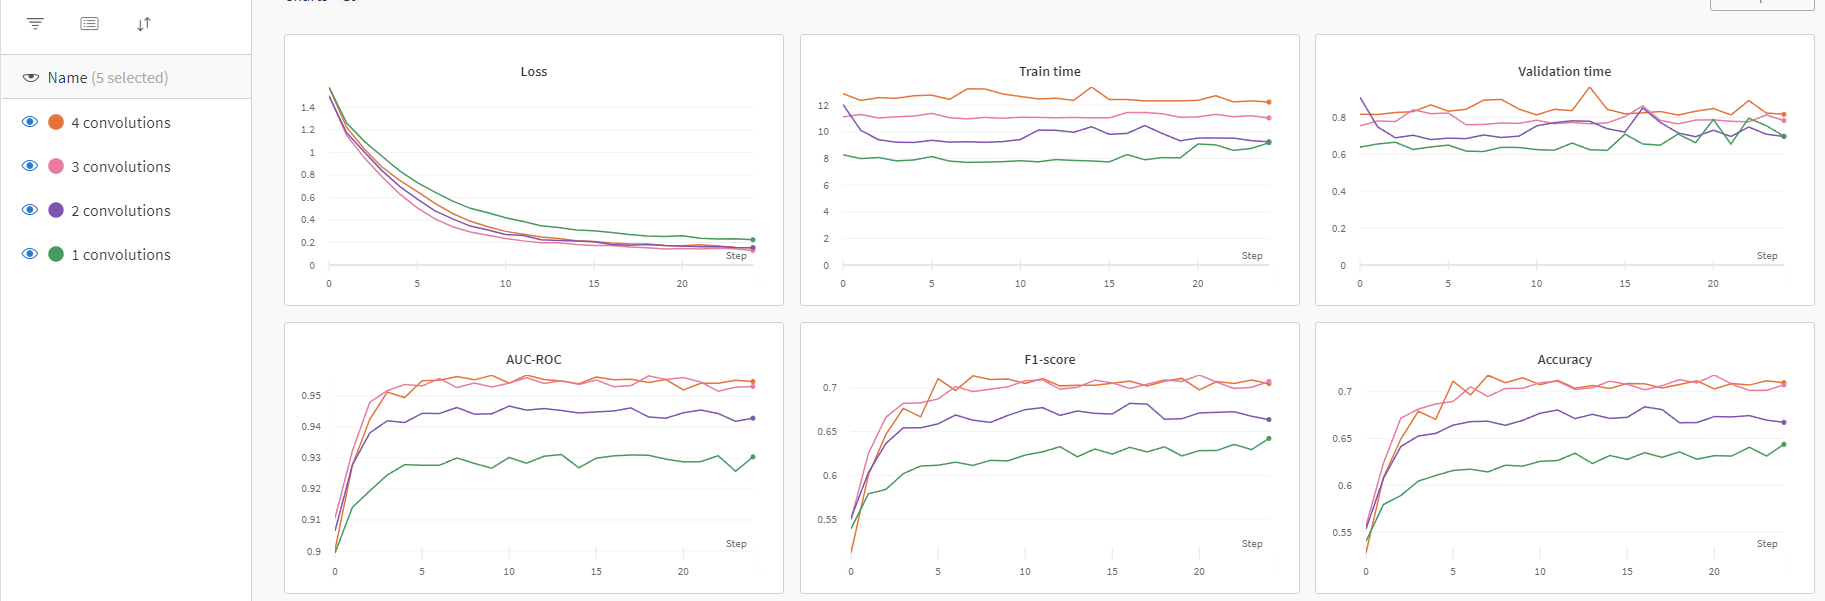

С увеличением количества свёрточных слоёв качество увеличивается, но сильнее проявляется и переобучение. Можно предположить, что оптимально использовать 5 свёрточных слоёв размера 7, чтобы поле восприятия последнего слоя равнялось всей картинке. Тем не менее при этом модель будет обучаться очень долго, и сильно проявится переобучение. Далее будем использовать 3 сверточных слоя: такая модель оказалась гораздо лучше, чем модель с двумя слоями, но лишь немного хуже модели с 4 сверточными слоями

### Pooling
Воспользуемся пулингом как альтернативным способом быстро повысить поле восприятия. Будем использовать 3 свёрточных слоя.

In [34]:
Classifier.results = [ ]

#### Один пулинг

In [35]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('1 Pooling (1)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:14<00:00,  7.76s/it]


AUC-ROC,▁▃▆▆▇▇▇▇█████████████████
Accuracy,▁▃▅▅▆▆▇▇██▇█▇████████████
F1-score,▁▃▅▅▆▆▇▇██▇█▇████████████
Loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Precision,▁▄▅▅▆▆▇▇█▇▇▇▇██████▇█████
Recall,▁▃▅▅▆▆▇▇██▇█▇████████████
TOP-2 Accuracy,▁▃▅▆▇▇▇▇██▇█████▇████████
TOP-3 Accuracy,▁▃▅▆▇▇▇▇▇▇▇██▇▇█▇██▇▇███▇
TOP-4 Accuracy,▁▃▅▅▆▇▇▇▇█▇▇█▇▇██▇▇▇▇█▇▇▇
TOP-5 Accuracy,▁▄▅▆▇▇▆▇▇█▇▇█▇▇▇█▇█▇██▇█▇
TOP-6 Accuracy,▁▃▅▆▇▆▆▇▇▇▇▆▇▆▇▇█▇█▇██▇█▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.996,0.999,0.961281,0.72571,0.729536,0.726657,0.716443,7.492159,0.39261,15


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               32             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           32             
├─1                          GELU                  (-1, 16, 32, 32)          0               26             
├─2                          MaxPool2d             (-1, 16, 16, 16)          0               26             
├─3                          Conv2d                (-1, 16, 16, 16)          12,560          13             
├─4                          GELU                  (-1, 16, 16, 16)          0               7              
├─5                          Conv2d                (-1, 16, 16, 16)          12,560          7              
├─6                

In [36]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('1 Pooling (2)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:27<00:00,  8.29s/it]


AUC-ROC,▁▄▆▇▇▇███████████████████
Accuracy,▁▄▆▆▇▇▇▇█████████████████
F1-score,▁▄▅▆▇▇█▇█████████████████
Loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▄▆▆▇▇███████████████████
Recall,▁▄▆▆▇▇▇▇█████████████████
TOP-2 Accuracy,▁▄▆▇▇▇████████████████▇██
TOP-3 Accuracy,▁▄▆▇▇▇█▇▇▇█████▇█▇███▇███
TOP-4 Accuracy,▁▄▆▆▇██▇▇██▇▇██▇████▇▇██▇
TOP-5 Accuracy,▁▄▆▇▇▇███████▇█▇█████▇█▇▇
TOP-6 Accuracy,▁▅▆▆█▇███▇▇█▇▇▇█▇▇▇██▆▇▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               26             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           26             
├─1                          GELU                  (-1, 16, 32, 32)          0               20             
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          20             
├─3                          GELU                  (-1, 16, 32, 32)          0               14             
├─4                          MaxPool2d             (-1, 16, 16, 16)          0               14             
├─5                          Conv2d                (-1, 16, 16, 16)          12,560          7              
├─6                

In [37]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('1 Pooling (3)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [04:07<00:00,  9.91s/it]


AUC-ROC,▁▄▅▆▇▇▇▇█████████████████
Accuracy,▁▃▅▅▆▇▇▇▇▇██▇▇▇█████████▇
F1-score,▁▃▅▅▆▇▇▇▇▇██▇▇▇█████████▇
Loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▅▅▆▇▇▇▇▇██▇▇▇█████████▇
Recall,▁▃▅▅▆▇▇▇▇▇██▇▇▇█████████▇
TOP-2 Accuracy,▁▄▅▆▇▇▇▇▇████████████████
TOP-3 Accuracy,▁▄▆▆▇█▇█████████████▇███▇
TOP-4 Accuracy,▁▄▅▆▇▇██▇█▇█▇█▇▇▇█▇█▇██▇▇
TOP-5 Accuracy,▁▄▆▆▇████▇▇█▇█▇▇█▇█▇▇▇█▇▇
TOP-6 Accuracy,▁▃▆▇▇████▇▇▇▇▇▇▇▇██▇▇██▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17
1 Pooling (3),,0.7500,0.8802,0.9328,0.9628,0.9784,0.9894,0.9938,0.9966,0.9992,0.964306,0.749312,0.748675,0.747936,0.729764,9.444444,0.254001,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               20             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           20             
├─1                          GELU                  (-1, 16, 32, 32)          0               14             
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          14             
├─3                          GELU                  (-1, 16, 32, 32)          0               8              
├─4                          Conv2d                (-1, 16, 32, 32)          12,560          8              
├─5                          GELU                  (-1, 16, 32, 32)          0               2              
├─6                

#### Два пулинга

In [38]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('2 Poolings (1-2)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:13<00:00,  7.73s/it]


AUC-ROC,▁▃▄▅▆▆▇▇▇▇▇▇█████████████
Accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇█▇██████████
F1-score,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇██████████
Loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇██████████
Recall,▁▃▄▅▅▅▆▆▇▇▇▇▇█▇██████████
TOP-2 Accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇█████████
TOP-3 Accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███▇████████
TOP-4 Accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇████████▇███
TOP-5 Accuracy,▁▃▅▅▇▆▆▇▇▇▇▇▇████▇▇▇█▇▇██
TOP-6 Accuracy,▁▃▄▆▇▆▇▇█▇▇▇▇█▇███▇██▇██▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17
1 Pooling (3),,0.7500,0.8802,0.9328,0.9628,0.9784,0.9894,0.9938,0.9966,0.9992,0.964306,0.749312,0.748675,0.747936,0.729764,9.444444,0.254001,23
2 Poolings (1-2),,0.7460,0.8844,0.9354,0.9648,0.9806,0.9880,0.9932,0.9968,0.9992,0.966617,0.744489,0.745684,0.743041,0.690923,6.721130,0.517206,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               46             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           46             
├─1                          GELU                  (-1, 16, 32, 32)          0               40             
├─2                          MaxPool2d             (-1, 16, 16, 16)          0               40             
├─3                          Conv2d                (-1, 16, 16, 16)          12,560          20             
├─4                          GELU                  (-1, 16, 16, 16)          0               14             
├─5                          MaxPool2d             (-1, 16, 8, 8)            0               14             
├─6                

In [39]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('2 Poolings (1-3)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:22<00:00,  8.10s/it]


AUC-ROC,▁▃▅▅▆▆▇▇▇▇▇▇█▇███████████
Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██▇████████
F1-score,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██▇████████
Loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██▇████████
Recall,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██▇████████
TOP-2 Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██▇████████
TOP-3 Accuracy,▁▃▅▅▅▆▆▇▇▇▇▇▇▇▇█▇█▇██████
TOP-4 Accuracy,▁▄▅▅▅▇▆▆▇▇▇▇▇▇██▇▇▇██████
TOP-5 Accuracy,▁▄▅▅▅▆▇▆▇▇▇▇▇▇█▇▇▇█▇█████
TOP-6 Accuracy,▁▃▅▆▅▆▇▆▇▇▇▇▇▇█▇▇▇███████


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17
1 Pooling (3),,0.7500,0.8802,0.9328,0.9628,0.9784,0.9894,0.9938,0.9966,0.9992,0.964306,0.749312,0.748675,0.747936,0.729764,9.444444,0.254001,23
2 Poolings (1-2),,0.7460,0.8844,0.9354,0.9648,0.9806,0.9880,0.9932,0.9968,0.9992,0.966617,0.744489,0.745684,0.743041,0.690923,6.721130,0.517206,24
2 Poolings (1-3),,0.7578,0.8868,0.9418,0.9694,0.9842,0.9920,0.9956,0.9978,1.0000,0.969260,0.756769,0.756738,0.756115,0.664588,6.622457,0.543334,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               34             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           34             
├─1                          GELU                  (-1, 16, 32, 32)          0               28             
├─2                          MaxPool2d             (-1, 16, 16, 16)          0               28             
├─3                          Conv2d                (-1, 16, 16, 16)          12,560          14             
├─4                          GELU                  (-1, 16, 16, 16)          0               8              
├─5                          Conv2d                (-1, 16, 16, 16)          12,560          8              
├─6                

In [40]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('2 Poolings (2-3)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:24<00:00,  8.17s/it]


AUC-ROC,▁▄▅▆▇▇▇▇▇████████████████
Accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇████████████
F1-score,▁▄▅▆▆▇▇▇▇▇▇▇▇█▇██████████
Loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Precision,▁▄▅▆▆▇▇▇▇▇▇▇▇█▇██████████
Recall,▁▃▅▆▆▇▇▇▇▇▇▇▇█▇██████████
TOP-2 Accuracy,▁▄▅▆▆▇▇▇▇▇▇█▇████████████
TOP-3 Accuracy,▁▄▅▆▇▇▇▇▇▇▇▇▇████████████
TOP-4 Accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇████████████
TOP-5 Accuracy,▁▄▅▆▆▇▇▇▇▇█▇█████████████
TOP-6 Accuracy,▁▄▅▆▆▇▇▇▇▇▇▇█████▇███▇█▇█


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17
1 Pooling (3),,0.7500,0.8802,0.9328,0.9628,0.9784,0.9894,0.9938,0.9966,0.9992,0.964306,0.749312,0.748675,0.747936,0.729764,9.444444,0.254001,23
2 Poolings (1-2),,0.7460,0.8844,0.9354,0.9648,0.9806,0.9880,0.9932,0.9968,0.9992,0.966617,0.744489,0.745684,0.743041,0.690923,6.721130,0.517206,24
2 Poolings (1-3),,0.7578,0.8868,0.9418,0.9694,0.9842,0.9920,0.9956,0.9978,1.0000,0.969260,0.756769,0.756738,0.756115,0.664588,6.622457,0.543334,23
2 Poolings (2-3),,0.7740,0.8960,0.9482,0.9756,0.9854,0.9906,0.9944,0.9980,0.9996,0.971947,0.773441,0.773088,0.772928,1.047589,8.750539,0.478161,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          GELU                  (-1, 16, 32, 32)          0               22             
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─3                          GELU                  (-1, 16, 32, 32)          0               16             
├─4                          MaxPool2d             (-1, 16, 16, 16)          0               16             
├─5                          Conv2d                (-1, 16, 16, 16)          12,560          8              
├─6                

#### Три пулинга

In [41]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('3 Poolings', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:38<00:00,  8.75s/it]


AUC-ROC,▁▃▄▅▆▆▇▇▇▇▇▇▇█▇██████████
Accuracy,▁▃▃▄▅▆▆▆▇▇▇▇▇▇▇██▇███▇█▇█
F1-score,▁▃▃▅▆▆▆▆▇▇▇▇▇▇▇██████▇███
Loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Precision,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇██████▇███
Recall,▁▃▃▄▅▆▆▆▇▇▇▇▇▇▇██▇███▇█▇█
TOP-2 Accuracy,▁▃▄▄▆▆▆▇▇▇▇▇▇█▇██████████
TOP-3 Accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇██████████
TOP-4 Accuracy,▁▄▄▅▆▇▇▇▇▇▇▇▇█▇██████████
TOP-5 Accuracy,▁▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇███████
TOP-6 Accuracy,▁▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇█▇██▇████


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17
1 Pooling (3),,0.7500,0.8802,0.9328,0.9628,0.9784,0.9894,0.9938,0.9966,0.9992,0.964306,0.749312,0.748675,0.747936,0.729764,9.444444,0.254001,23
2 Poolings (1-2),,0.7460,0.8844,0.9354,0.9648,0.9806,0.9880,0.9932,0.9968,0.9992,0.966617,0.744489,0.745684,0.743041,0.690923,6.721130,0.517206,24
2 Poolings (1-3),,0.7578,0.8868,0.9418,0.9694,0.9842,0.9920,0.9956,0.9978,1.0000,0.969260,0.756769,0.756738,0.756115,0.664588,6.622457,0.543334,23
2 Poolings (2-3),,0.7740,0.8960,0.9482,0.9756,0.9854,0.9906,0.9944,0.9980,0.9996,0.971947,0.773441,0.773088,0.772928,1.047589,8.750539,0.478161,24
3 Poolings,,0.7160,0.8628,0.9282,0.9594,0.9762,0.9880,0.9946,0.9978,0.9994,0.959119,0.712262,0.715137,0.711737,0.792441,8.404694,0.766521,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               50             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           50             
├─1                          GELU                  (-1, 16, 32, 32)          0               44             
├─2                          MaxPool2d             (-1, 16, 16, 16)          0               44             
├─3                          Conv2d                (-1, 16, 16, 16)          12,560          22             
├─4                          GELU                  (-1, 16, 16, 16)          0               16             
├─5                          MaxPool2d             (-1, 16, 8, 8)            0               16             
├─6                

![Alternative Text][1697991969065]

[1697991969065]: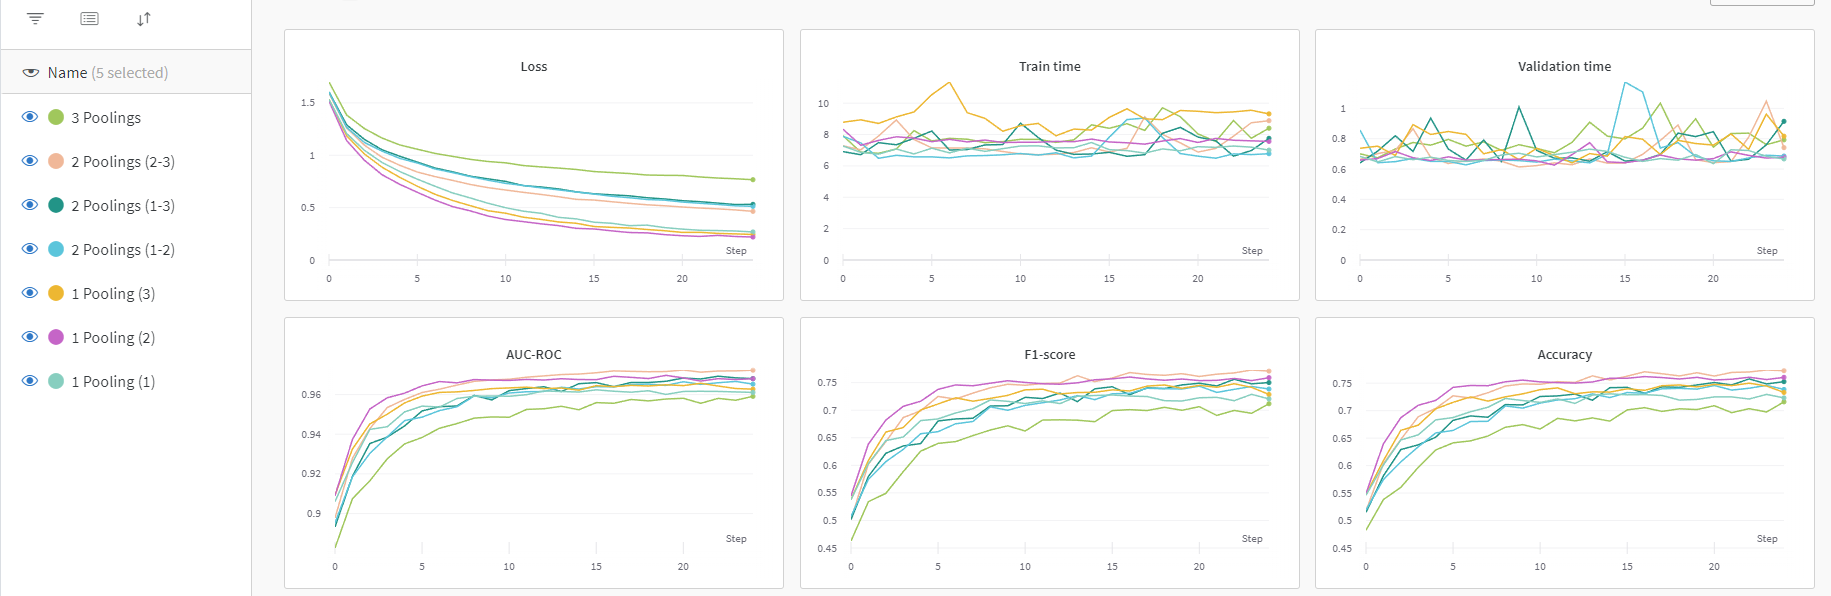

Ожидаемо, худшее качество показывает модель с тремя пулинг-слоями: ее поле восприятия значительно превышает размер входной картинки. Лучшее качество показывают модели с одним пулинг-слоем после второй свертки и с двумя пулинг-слоями после второго и третьего сверточных слоёв: они "видят" почти всю картинку, но и создают достаточное количество признаков для обучения полносвязного слоя.

#### Average pooling

In [42]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.AvgPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.GELU(), torch.nn.AvgPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('Average pooling', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:30<00:00,  8.43s/it]


AUC-ROC,▁▃▅▆▆▇▇▇▇▇▇██▇███████████
Accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇███████████
F1-score,▁▃▄▅▆▆▇▇▇▇▇▇▇▇███████████
Loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Precision,▁▃▄▅▆▆▇▇▇▇▇▇█▇███████████
Recall,▁▃▄▅▆▆▇▇▇▇▇▇▇▇███████████
TOP-2 Accuracy,▁▃▄▅▆▆▇▇▇▇▇▇█▇███████████
TOP-3 Accuracy,▁▄▅▆▆▆▇▇▇▇▇▇█▇███████████
TOP-4 Accuracy,▁▄▅▆▆▆▇▇▇▇▇█▇▇█▇█▇███▇███
TOP-5 Accuracy,▁▄▅▆▇▇▇▇▇▇███████████████
TOP-6 Accuracy,▁▄▅▇▇▇▇█▇▇▇█▇██▇█████▇▇██


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
1 Pooling (1),,0.7306,0.8632,0.9238,0.9572,0.9766,0.9864,0.9934,0.9960,0.9990,0.961281,0.725710,0.729536,0.726657,0.716443,7.492159,0.392610,15
1 Pooling (2),,0.7620,0.8912,0.9420,0.9692,0.9840,0.9892,0.9938,0.9968,0.9992,0.969205,0.760648,0.761237,0.760161,0.658404,7.473838,0.278365,17
1 Pooling (3),,0.7500,0.8802,0.9328,0.9628,0.9784,0.9894,0.9938,0.9966,0.9992,0.964306,0.749312,0.748675,0.747936,0.729764,9.444444,0.254001,23
2 Poolings (1-2),,0.7460,0.8844,0.9354,0.9648,0.9806,0.9880,0.9932,0.9968,0.9992,0.966617,0.744489,0.745684,0.743041,0.690923,6.721130,0.517206,24
2 Poolings (1-3),,0.7578,0.8868,0.9418,0.9694,0.9842,0.9920,0.9956,0.9978,1.0000,0.969260,0.756769,0.756738,0.756115,0.664588,6.622457,0.543334,23
2 Poolings (2-3),,0.7740,0.8960,0.9482,0.9756,0.9854,0.9906,0.9944,0.9980,0.9996,0.971947,0.773441,0.773088,0.772928,1.047589,8.750539,0.478161,24
3 Poolings,,0.7160,0.8628,0.9282,0.9594,0.9762,0.9880,0.9946,0.9978,0.9994,0.959119,0.712262,0.715137,0.711737,0.792441,8.404694,0.766521,25
Average pooling,,0.7686,0.9008,0.9462,0.9720,0.9844,0.9930,0.9968,0.9984,0.9996,0.971676,0.764801,0.767334,0.765160,0.715877,7.785682,0.550703,20


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          GELU                  (-1, 16, 32, 32)          0               22             
├─2                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─3                          GELU                  (-1, 16, 32, 32)          0               16             
├─4                          AvgPool2d             (-1, 16, 16, 16)          0               16             
├─5                          Conv2d                (-1, 16, 16, 16)          12,560          8              
├─6                

![Alternative Text][1697992028306]

[1697992028306]: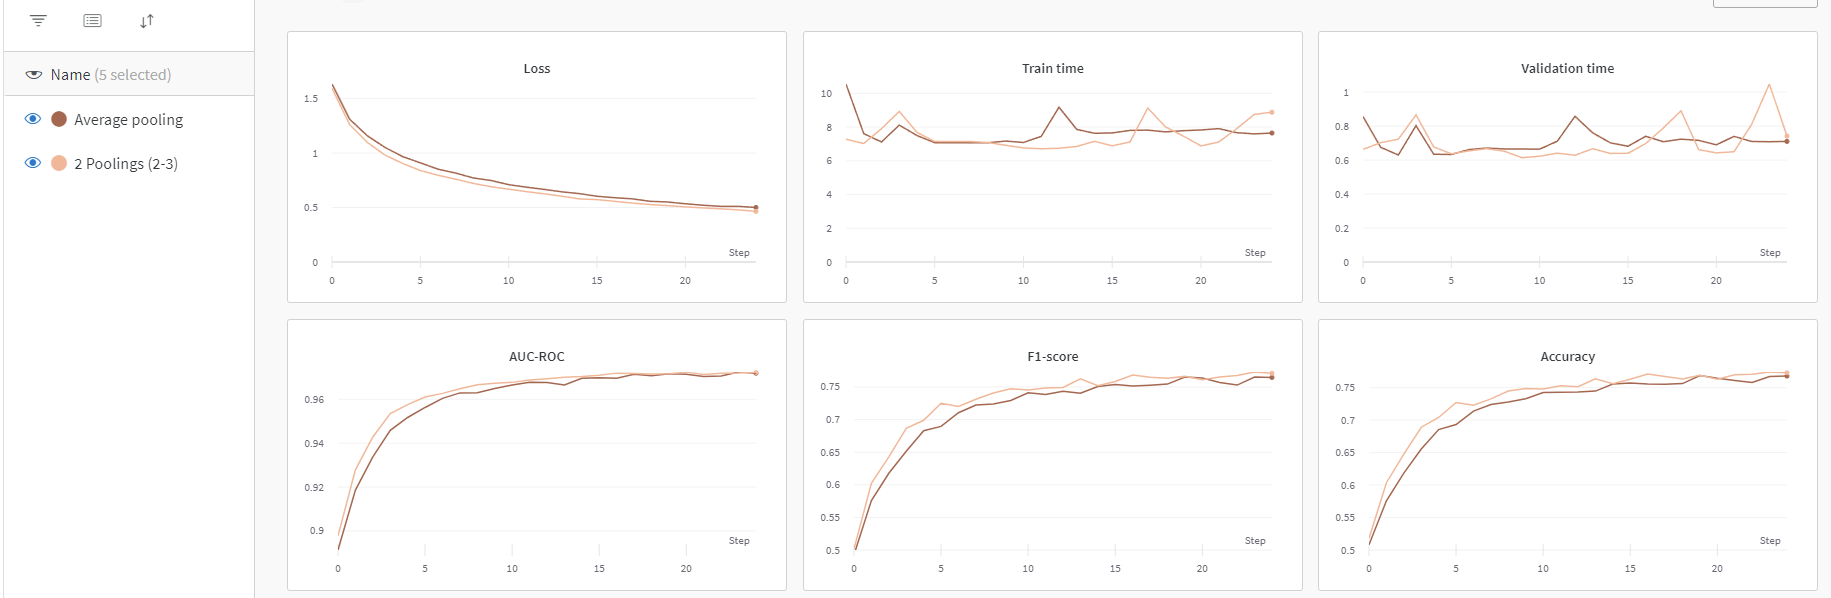

Average pooling показал себя немного хуже Maximum Pooling. Далее будем использовать модель с двумя MaxPool-слоями после второй и третьей сверток

### Нормализация

In [43]:
Classifier.results = [ ]

In [44]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('BatchNorm', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:42<00:00,  8.92s/it]


AUC-ROC,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇█▇████████
Accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████
F1-score,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████
Loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇████████
Recall,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████
TOP-2 Accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
TOP-3 Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██▇▇███████
TOP-4 Accuracy,▁▃▅▅▆▆▆▆▇█▇▇▇███▇████████
TOP-5 Accuracy,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███▇▇██
TOP-6 Accuracy,▁▃▄▅▅▅▆▇▆▇▇▇▇▇▇▇▇▇██▇▇▇▇█


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.786,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.999,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          BatchNorm2d           (-1, 16, 32, 32)          65              22             
├─2                          GELU                  (-1, 16, 32, 32)          0               22             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─4                          BatchNorm2d           (-1, 16, 32, 32)          65              16             
├─5                          GELU                  (-1, 16, 32, 32)          0               16             
├─6                

In [45]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.InstanceNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.InstanceNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.InstanceNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.InstanceNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('InstanceNorm', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:47<00:00,  9.10s/it]


AUC-ROC,▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇██████████
Accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇█▇█▇██████
F1-score,▁▂▄▄▅▅▆▆▆▇▇▆▇▇▇█▇█▇██████
Loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇███▇██████
Recall,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇█▇█▇██████
TOP-2 Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇████████
TOP-3 Accuracy,▁▃▄▅▅▆▆▆▇▆▇▇▇▇▇▇█▇▇█▇████
TOP-4 Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇███████████
TOP-5 Accuracy,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇██████████
TOP-6 Accuracy,▁▄▄▆▆▆▇▇▇▇▇▇▇█▇██▇▇██████


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          InstanceNorm2d        (-1, 16, 32, 32)          0               22             
├─2                          GELU                  (-1, 16, 32, 32)          0               22             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─4                          InstanceNorm2d        (-1, 16, 32, 32)          0               16             
├─5                          GELU                  (-1, 16, 32, 32)          0               16             
├─6                

In [46]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LayerNorm((16, 32, 32)), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LayerNorm((16, 32, 32)), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LayerNorm((16, 16, 16)), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.LayerNorm((1024)), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('LayerNorm', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:52<00:00,  9.29s/it]


AUC-ROC,▁▃▄▅▆▆▆▇▇▇▇▇▇▇█▇█████████
Accuracy,▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████
F1-score,▁▃▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇████████
Recall,▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████
TOP-2 Accuracy,▁▃▄▄▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇██████
TOP-3 Accuracy,▁▃▄▅▅▆▆▆▇▆▇▇▇▇█▇▇█▇██████
TOP-4 Accuracy,▁▃▄▄▆▆▆▇▇▆▇▇▇▇▇▇▇█▇██████
TOP-5 Accuracy,▁▄▄▅▆▇▆▇▇▆▇▇█▇▇▇▇▇▇███▇██
TOP-6 Accuracy,▁▄▄▅▆▇▆▇▇▆▇▇█▇█▇█▇▇█████▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          LayerNorm             (-1, 16, 32, 32)          32,768          22             
├─2                          GELU                  (-1, 16, 32, 32)          0               22             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─4                          LayerNorm             (-1, 16, 32, 32)          32,768          16             
├─5                          GELU                  (-1, 16, 32, 32)          0               16             
├─6                

In [47]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LocalResponseNorm(2), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LocalResponseNorm(2), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LocalResponseNorm(2), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('LocalResponseNorm(2)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [04:14<00:00, 10.18s/it]


AUC-ROC,▁▃▅▆▆▆▇▇▇▇▇▇▇████████████
Accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇███████████
F1-score,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇██████████
Loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇██████████
Recall,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇██████████
TOP-2 Accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇███████████
TOP-3 Accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇███▇███████
TOP-4 Accuracy,▁▃▅▆▆▇▇▇▇▇▇█▇▇███████████
TOP-5 Accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇█▇▇█████▇█▇
TOP-6 Accuracy,▁▃▅▆▅▆▇▇▇▇▇█▇██▇██████▇▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23
LocalResponseNorm(2),,0.7764,0.9054,0.9498,0.9732,0.9854,0.9928,0.9972,0.9988,0.9996,0.972398,0.773680,0.776053,0.772879,0.925403,9.172982,0.602165,16


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          LocalResponseNorm     (-1, 16, 32, 32)          0               22             
├─2                          GELU                  (-1, 16, 32, 32)          0               22             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─4                          LocalResponseNorm     (-1, 16, 32, 32)          0               16             
├─5                          GELU                  (-1, 16, 32, 32)          0               16             
├─6                

In [48]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LocalResponseNorm(8), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LocalResponseNorm(8), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.LocalResponseNorm(8), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('LocalResponseNorm(8)', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [04:22<00:00, 10.48s/it]


AUC-ROC,▁▄▅▆▆▇▇▇▇▇▇██████████████
Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇█▇███▇██████
F1-score,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇███▇██████
Loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇███▇██████
Recall,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇███▇██████
TOP-2 Accuracy,▁▃▄▅▆▇▇▇▇▇▇▇▇████████████
TOP-3 Accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇████████████
TOP-4 Accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇████████████
TOP-5 Accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████▇██
TOP-6 Accuracy,▁▃▅▆▆▇▇▇▇▇▇██▇█▇███▇██▇█▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23
LocalResponseNorm(2),,0.7764,0.9054,0.9498,0.9732,0.9854,0.9928,0.9972,0.9988,0.9996,0.972398,0.773680,0.776053,0.772879,0.925403,9.172982,0.602165,16
LocalResponseNorm(8),,0.7778,0.9006,0.9492,0.9702,0.9868,0.9932,0.9962,0.9984,0.9998,0.972971,0.777338,0.777103,0.776328,0.735547,9.253781,0.505465,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               28             
├─0                          Conv2d                (-1, 16, 32, 32)          2,368           28             
├─1                          LocalResponseNorm     (-1, 16, 32, 32)          0               22             
├─2                          GELU                  (-1, 16, 32, 32)          0               22             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          22             
├─4                          LocalResponseNorm     (-1, 16, 32, 32)          0               16             
├─5                          GELU                  (-1, 16, 32, 32)          0               16             
├─6                

![Alternative Text][1697992116858]

[1697992116858]: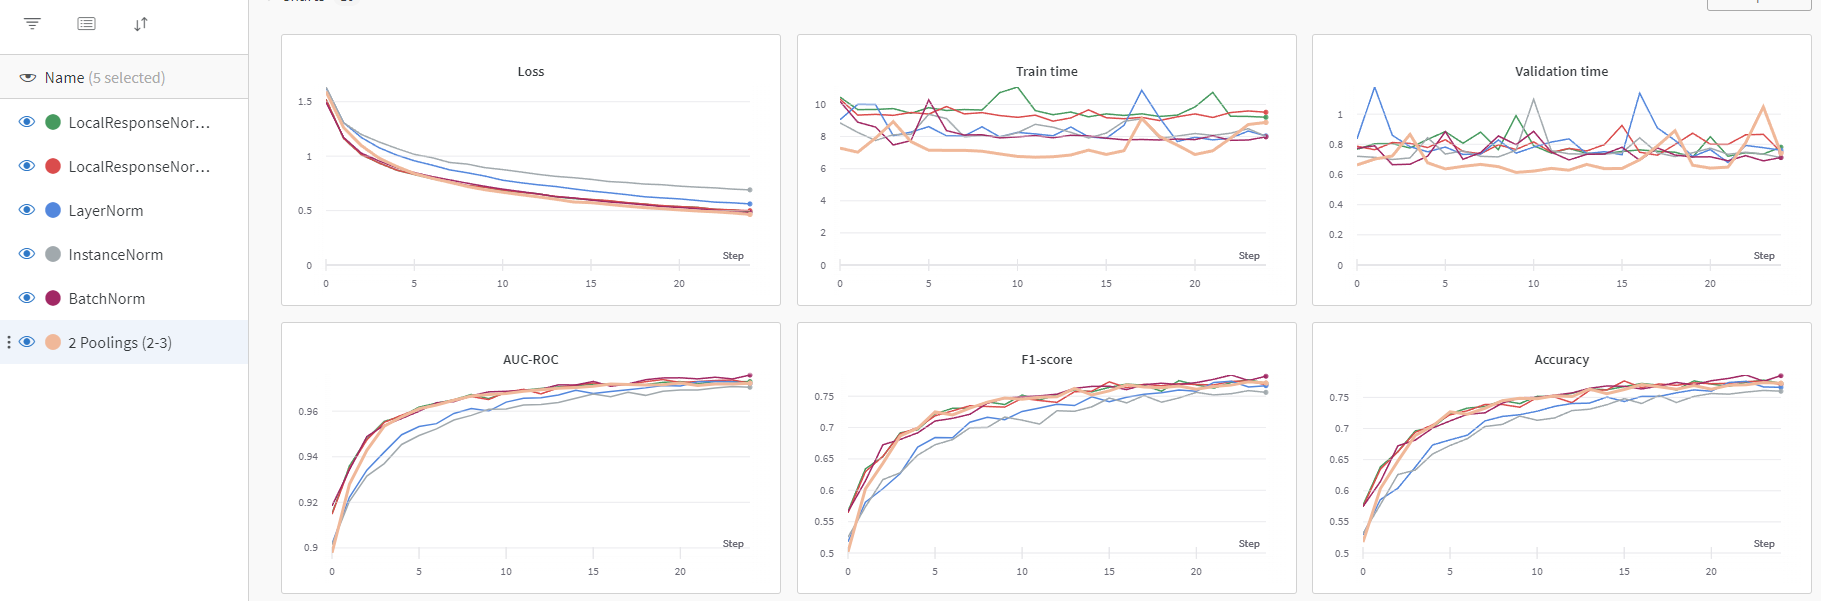

BatchNorm показывает себя немного лучше остальных алгоритмов нормализации

### Другие эксперименты

Интуиция подсказывает, что целесообрзно комбинировать свертки разного размера.

In [49]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 2), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 9, padding = 4), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('Idea - 1.1', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:22<00:00,  8.12s/it]


AUC-ROC,▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇██████████
Accuracy,▁▃▄▅▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇█▇█▇█▇
F1-score,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇█▇
Loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇██▇████
Recall,▁▃▄▅▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇█▇█▇█▇
TOP-2 Accuracy,▁▄▄▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇█▇█▇
TOP-3 Accuracy,▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇██▇▇███▇██
TOP-4 Accuracy,▁▄▄▆▆▆▆▇▇▇▇█▇▇██▇█▇█▇█▇██
TOP-5 Accuracy,▁▄▄▆▆▅▆▇▇▇▇███████▇█████▇
TOP-6 Accuracy,▁▄▄▆▆▅▆▇▇▇▇████▇▇▇▇█▇▇▇█▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23
LocalResponseNorm(2),,0.7764,0.9054,0.9498,0.9732,0.9854,0.9928,0.9972,0.9988,0.9996,0.972398,0.773680,0.776053,0.772879,0.925403,9.172982,0.602165,16
LocalResponseNorm(8),,0.7778,0.9006,0.9492,0.9702,0.9868,0.9932,0.9962,0.9984,0.9998,0.972971,0.777338,0.777103,0.776328,0.735547,9.253781,0.505465,24
Idea - 1.1,,0.7916,0.9110,0.9522,0.9734,0.9874,0.9934,0.9970,0.9982,0.9992,0.976345,0.789668,0.790710,0.789019,0.636951,6.812001,0.463458,24


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               30             
├─0                          Conv2d                (-1, 16, 32, 32)          1,216           30             
├─1                          BatchNorm2d           (-1, 16, 32, 32)          65              26             
├─2                          GELU                  (-1, 16, 32, 32)          0               26             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          26             
├─4                          BatchNorm2d           (-1, 16, 32, 32)          65              20             
├─5                          GELU                  (-1, 16, 32, 32)          0               20             
├─6                

In [50]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 9, padding = 4), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 2), torch.nn.BatchNorm2d(16), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('Idea - 1.2', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:38<00:00,  8.75s/it]


AUC-ROC,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇██████████
Accuracy,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇███████
F1-score,▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇█▇███████
Loss,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Precision,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████████
Recall,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇██▇████
TOP-2 Accuracy,▁▃▄▅▅▆▆▇▆▇▇▇▇▇▇▇█▇▇█▇████
TOP-3 Accuracy,▁▃▄▅▆▆▇▇▆▇▇▇▇█▇██████████
TOP-4 Accuracy,▁▄▄▆▆▆▇▇▆▇▇███▇██████████
TOP-5 Accuracy,▁▅▅▆▆▆▇▇▆▇████▇█████▇████
TOP-6 Accuracy,▁▅▄▆▆▆▇▇▆█▇██▇▇▇█▇██▇███▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23
LocalResponseNorm(2),,0.7764,0.9054,0.9498,0.9732,0.9854,0.9928,0.9972,0.9988,0.9996,0.972398,0.773680,0.776053,0.772879,0.925403,9.172982,0.602165,16
LocalResponseNorm(8),,0.7778,0.9006,0.9492,0.9702,0.9868,0.9932,0.9962,0.9984,0.9998,0.972971,0.777338,0.777103,0.776328,0.735547,9.253781,0.505465,24
Idea - 1.1,,0.7916,0.9110,0.9522,0.9734,0.9874,0.9934,0.9970,0.9982,0.9992,0.976345,0.789668,0.790710,0.789019,0.636951,6.812001,0.463458,24
Idea - 1.2,,0.7822,0.9048,0.9534,0.9756,0.9860,0.9916,0.9966,0.9982,0.9992,0.975022,0.779266,0.781577,0.779200,0.816907,7.862361,0.507531,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               26             
├─0                          Conv2d                (-1, 16, 32, 32)          3,904           26             
├─1                          BatchNorm2d           (-1, 16, 32, 32)          65              18             
├─2                          GELU                  (-1, 16, 32, 32)          0               18             
├─3                          Conv2d                (-1, 16, 32, 32)          12,560          18             
├─4                          BatchNorm2d           (-1, 16, 32, 32)          65              12             
├─5                          GELU                  (-1, 16, 32, 32)          0               12             
├─6                

![Alternative Text][1697992437770]

[1697992437770]: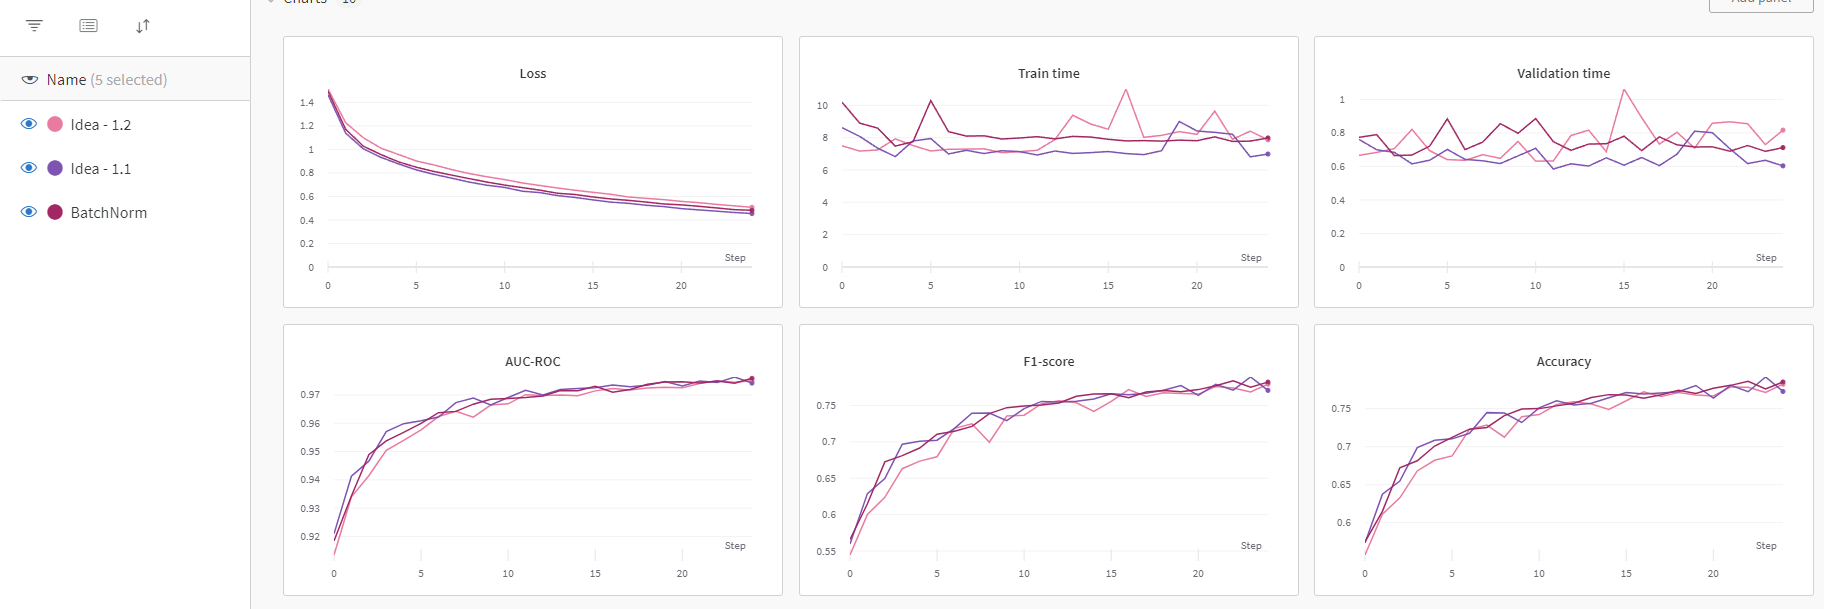

Действительно, при постепенном увеличении размеров ядер сверток модель достигает лучшего качества. Тем не менее при постепенном уменьшении размеров ядер качество, напротив, оказывается ниже. \
Попробуем изменить количество фильтров в промежуточных слоях.

In [51]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 2), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('Idea - 2', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [03:52<00:00,  9.31s/it]


AUC-ROC,▁▃▄▅▆▇▆▇▇▇█▇█████████████
Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇█▇█▇▇▇▇▇█████
F1-score,▁▃▄▅▅▆▆▇▇▇▇▇▇▇█▇▇█▇▇█████
Loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Precision,▁▃▄▅▅▆▆▇▇▇▇▇▇██▇▇█▇▇█████
Recall,▁▃▄▅▅▆▆▇▇▇▇▇█▇█▇▇▇▇▇█████
TOP-2 Accuracy,▁▃▄▅▆▇▆▇▇▇▇▇▇▇█▇▇▇▇▇███▇█
TOP-3 Accuracy,▁▃▄▅▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█████
TOP-4 Accuracy,▁▃▄▆▅▇▆▇▇▇▇▇▇██▇▇▇▇█████▇
TOP-5 Accuracy,▁▃▄▅▅▇▆█▇▇▇▇▇▇█▇▆▇█▇▇█▇█▇
TOP-6 Accuracy,▁▃▄▅▆▆▆▇▆█▇▇▇██▇▆▇▇▇██▇▇▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23
LocalResponseNorm(2),,0.7764,0.9054,0.9498,0.9732,0.9854,0.9928,0.9972,0.9988,0.9996,0.972398,0.773680,0.776053,0.772879,0.925403,9.172982,0.602165,16
LocalResponseNorm(8),,0.7778,0.9006,0.9492,0.9702,0.9868,0.9932,0.9962,0.9984,0.9998,0.972971,0.777338,0.777103,0.776328,0.735547,9.253781,0.505465,24
Idea - 1.1,,0.7916,0.9110,0.9522,0.9734,0.9874,0.9934,0.9970,0.9982,0.9992,0.976345,0.789668,0.790710,0.789019,0.636951,6.812001,0.463458,24
Idea - 1.2,,0.7822,0.9048,0.9534,0.9756,0.9860,0.9916,0.9966,0.9982,0.9992,0.975022,0.779266,0.781577,0.779200,0.816907,7.862361,0.507531,25
Idea - 2,,0.8144,0.9254,0.9622,0.9792,0.9872,0.9922,0.9952,0.9978,0.9996,0.980945,0.815189,0.813683,0.812497,0.644664,8.203374,0.244739,23


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               30             
├─0                          Conv2d                (-1, 16, 32, 32)          1,216           30             
├─1                          BatchNorm2d           (-1, 16, 32, 32)          65              26             
├─2                          GELU                  (-1, 16, 32, 32)          0               26             
├─3                          Conv2d                (-1, 32, 32, 32)          25,120          26             
├─4                          BatchNorm2d           (-1, 32, 32, 32)          129             20             
├─5                          GELU                  (-1, 32, 32, 32)          0               20             
├─6                

![Alternative Text][1697992621841]

[1697992621841]: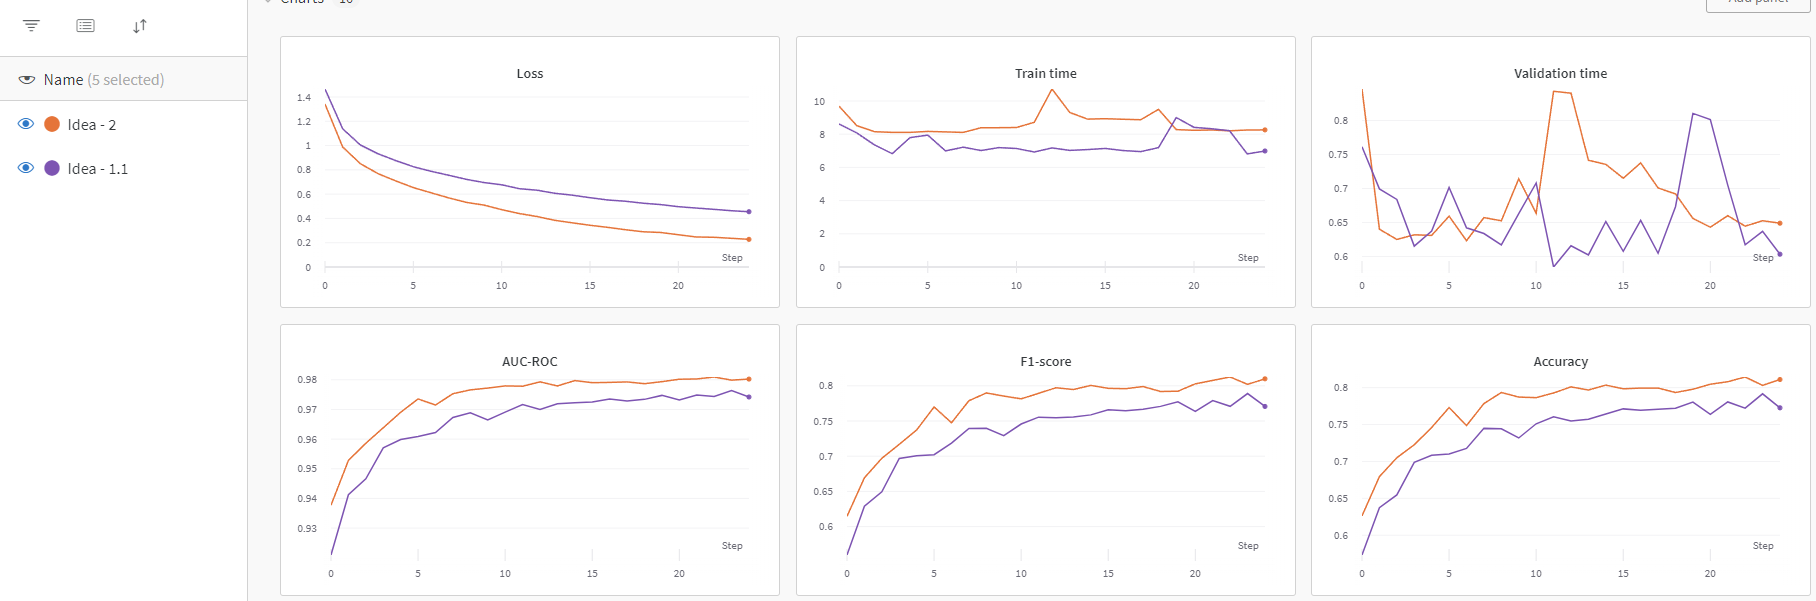

Стало значительно лучше \
Попробуем добавить ещё один слой, чтобы повысить поле восприятия до всей картинки

In [52]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 2), torch.nn.BatchNorm2d(32), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 9, padding = 4), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
Classifier('Idea - 3', model).fit(train_set, val_set).summary()

100%|██████████| 25/25 [06:43<00:00, 16.13s/it]


AUC-ROC,▁▄▆▆▇▆▇▇█▇███████████████
Accuracy,▁▄▅▆▆▅▇▇▇▇▇███████▇██████
F1-score,▁▄▅▆▆▅▇▇▇▇▇███▇███▇██████
Loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▅▅▆▆▆▇▇▇▇██████████████
Recall,▁▄▅▆▆▅▆▇▇▇▇▇██▇███▇██████
TOP-2 Accuracy,▁▄▆▆▆▆▇▇▇▇▇███████▇██████
TOP-3 Accuracy,▁▄▅▆▆▆▇▇██▇███▇███▇██████
TOP-4 Accuracy,▁▄▆▆▆▆▇▇▇▇▇██▇▇███▇██▇███
TOP-5 Accuracy,▁▄▆▆▆▆▇▇▇▇▇█▇▇▆▇▇█▇▇▇█▇▇▇
TOP-6 Accuracy,▁▄▆▆▇▆█▇█████▇▇▇██████▇█▇


,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
BatchNorm,,0.7860,0.9124,0.9562,0.9766,0.9852,0.9902,0.9948,0.9982,0.9990,0.974913,0.783792,0.784983,0.783794,0.725086,7.765477,0.502367,23
InstanceNorm,,0.7612,0.8912,0.9456,0.9706,0.9846,0.9912,0.9960,0.9972,0.9996,0.970856,0.761110,0.760759,0.758845,0.735408,8.490787,0.697187,24
LayerNorm,,0.7758,0.8998,0.9482,0.9714,0.9830,0.9918,0.9946,0.9978,0.9994,0.973029,0.775683,0.774852,0.773955,0.792610,7.898940,0.577615,23
LocalResponseNorm(2),,0.7764,0.9054,0.9498,0.9732,0.9854,0.9928,0.9972,0.9988,0.9996,0.972398,0.773680,0.776053,0.772879,0.925403,9.172982,0.602165,16
LocalResponseNorm(8),,0.7778,0.9006,0.9492,0.9702,0.9868,0.9932,0.9962,0.9984,0.9998,0.972971,0.777338,0.777103,0.776328,0.735547,9.253781,0.505465,24
Idea - 1.1,,0.7916,0.9110,0.9522,0.9734,0.9874,0.9934,0.9970,0.9982,0.9992,0.976345,0.789668,0.790710,0.789019,0.636951,6.812001,0.463458,24
Idea - 1.2,,0.7822,0.9048,0.9534,0.9756,0.9860,0.9916,0.9966,0.9982,0.9992,0.975022,0.779266,0.781577,0.779200,0.816907,7.862361,0.507531,25
Idea - 2,,0.8144,0.9254,0.9622,0.9792,0.9872,0.9922,0.9952,0.9978,0.9996,0.980945,0.815189,0.813683,0.812497,0.644664,8.203374,0.244739,23
Idea - 3,,0.8388,0.9386,0.9698,0.9838,0.9914,0.9950,0.9968,0.9984,0.9990,0.984935,0.839668,0.839081,0.837505,0.907571,15.289456,0.082248,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               32             
├─0                          Conv2d                (-1, 16, 32, 32)          448             32             
├─1                          BatchNorm2d           (-1, 16, 32, 32)          65              30             
├─2                          GELU                  (-1, 16, 32, 32)          0               30             
├─3                          Conv2d                (-1, 32, 32, 32)          12,832          30             
├─4                          BatchNorm2d           (-1, 32, 32, 32)          129             26             
├─5                          GELU                  (-1, 32, 32, 32)          0               26             
├─6                

![Alternative Text][1697993062089]

[1697993062089]: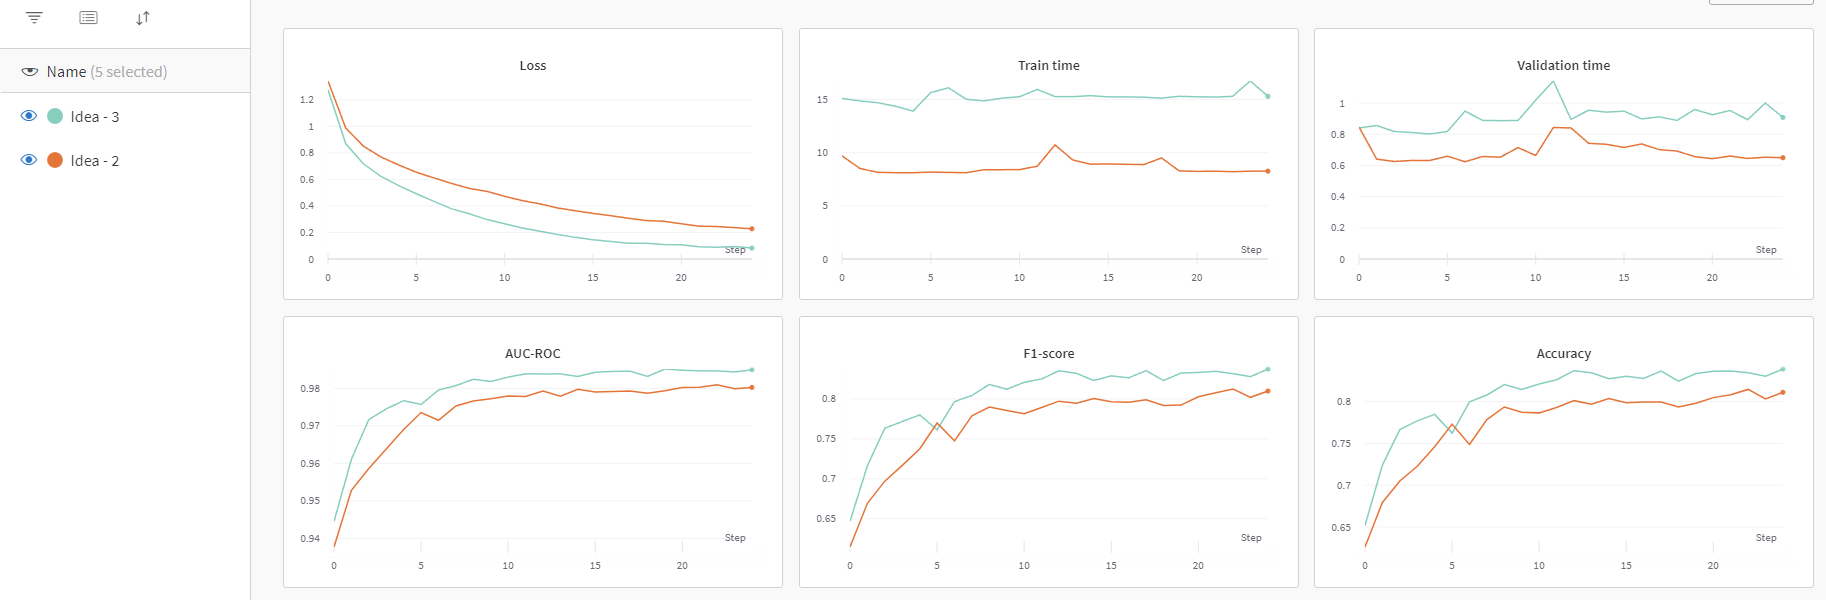

## Train the model




### Validate results on test dataset

You must get accuracy above 0.65

In [55]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 2), torch.nn.BatchNorm2d(32), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7, padding = 3), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 9, padding = 4), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(1024, 10)
)
final_model = Classifier('Final model', model).fit(train_set, val_set)
final_model.calc_metrics(test_set)

100%|██████████| 25/25 [07:42<00:00, 18.52s/it]


AUC-ROC,▁▄▆▆▇▇▇▇█████████████████
Accuracy,▁▃▅▅▆▆▇▇█▇▇██▇▇█▇████████
F1-score,▁▃▅▅▆▆▇▇█▇▇███▇██████████
Loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Precision,▁▃▅▅▆▆▇▇██▇█▇█▇█▇████████
Recall,▁▃▅▅▆▆▇▇█▇▇██▇▇█▇████████
TOP-2 Accuracy,▁▄▅▆▆▆▇▇██████▇▇▇████████
TOP-3 Accuracy,▁▄▆▆▆▆▇▇█▇▇███▇██████████
TOP-4 Accuracy,▁▅▆▆▆▆█▇█▇██▇█▇██▇▇█████▇
TOP-5 Accuracy,▁▅▆▇▆▆███▇█▇▇█▇▇█▇▇█▇█▇█▇
TOP-6 Accuracy,▁▅▆▅▄▆▇█▇▇▆▇▇▇▆▇▇▆▆▇▇▇▇█▆


{'': '',
 'Accuracy': 0.8352,
 'TOP-2 Accuracy': 0.9303,
 'TOP-3 Accuracy': 0.9655,
 'TOP-4 Accuracy': 0.9841,
 'TOP-5 Accuracy': 0.9916,
 'TOP-6 Accuracy': 0.9955,
 'TOP-7 Accuracy': 0.9968,
 'TOP-8 Accuracy': 0.9992,
 'TOP-9 Accuracy': 0.9996,
 'AUC-ROC': 0.98445015,
 'Precision': 0.8348483508371712,
 'Recall': 0.8352,
 'F1-score': 0.8343635380495138}

In [56]:
def validate(model, testloader, device = "cpu"):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    return correct / total

validate(final_model.model, torchdata.DataLoader(test_set, batch_size = 512), device)

0.8352

![Alternative Text][1697994111257]

[1697994111257]: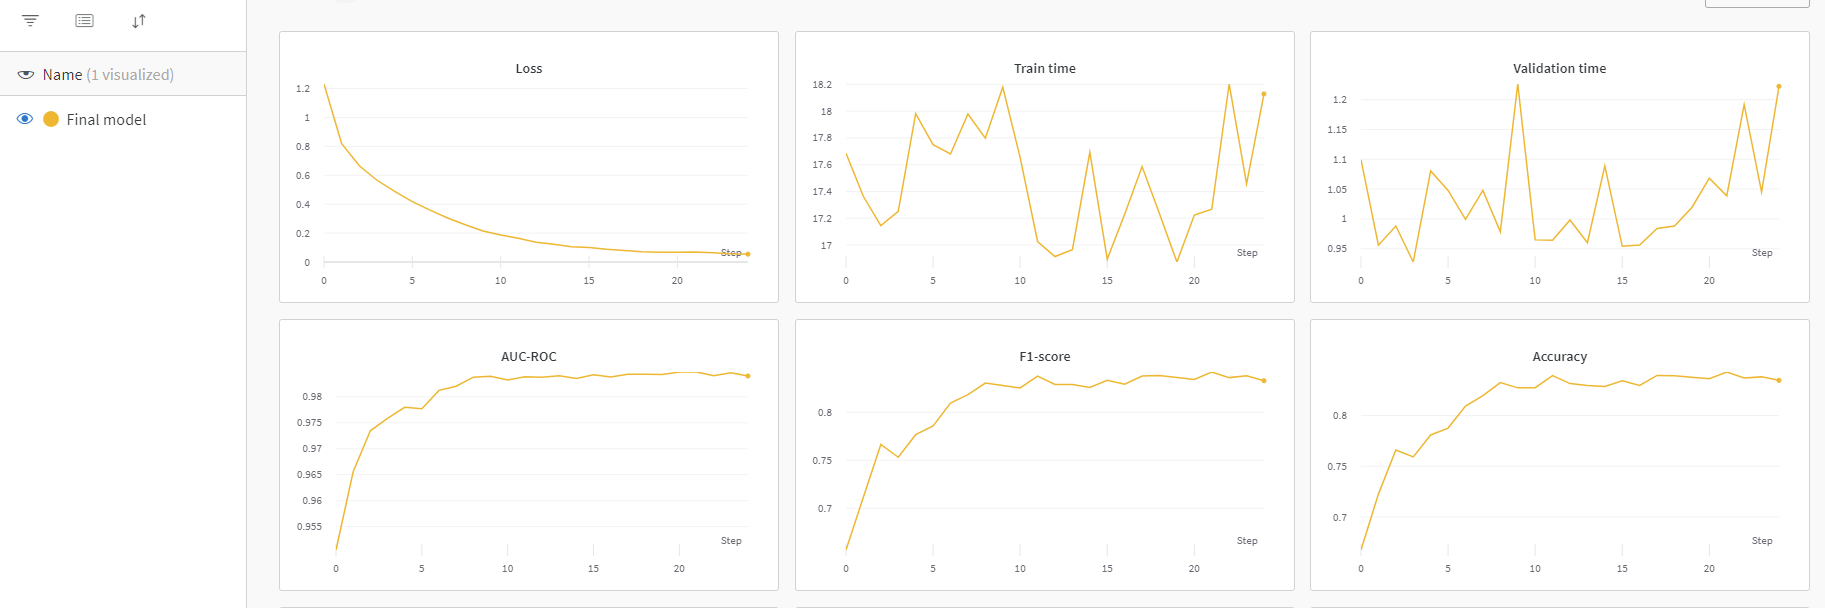

# Place for brief conclusion:
Добавление сверточных слоев позволяет значительно повысить качество: сеть, содержащая только полносвязные слои, верно предсказывает класс лишь для 58% объектов, в то время как использование сверточных слоев позволяет повысить значение этой метрики до `83.5%`. Более того, для сверточной сети верный класс оказывается среди двух наиболее вероятных в более, чем 93% случаев (для полносвязной сети эта метрика была лишь 75%), а среди пяти - в более, чем 99% случаев. Также заметим, что AUC-ROC и F-мера заметно увеличились и составили 0.984 и 0.834 соответственно против 0.905 и 0.578 для модели, состоящей только из полносвязных слоев. Таким образом, сверточная нейронная сеть показывает себя гораздо лучше полносвязной при решении задачи классифицкации картинок. Тем не менее обучение и применение таких моделей - сложные операции, требующие большого количества вычислительных ресурсов. \
 \
Выбор архитектуры и гиперпараметров модели может оказывать значительное влияние на качество:
- Подбор размеров ядер сверточных слоев позволяет значительно повысить долю объектов, для которых класс определяется верно
- Добавление padding при выполнении свертки позволяет немного улучшить результат
- Способ заполнения padding не оказывает значительного влияния на качество модели
- При использовании одного сверточного слоя количество фильтров не оказывает видимого влияния на качество. Тем не менее изменение значения этого гиперпараметра может позволить значительно улучшить результат в более сложных моделях, содержащих несколько сверточных слоев
- Количество сверточных слоев, ожидаемо, сильно влияет на обобщающую способность модели, но слишком большое количество слоев приводит к потере информации (если поле восприятия оказывается больше размера входной картинки) или к переобучению
- Пулинг - хороший способ повышения поля восприятия модели, не ведущий к переобучению.
    - Применять пулинг следует возле последних сверточных слоев во избежание потери данных моделью.
    - При применении пулинга следует контролировать, чтобы поле восприятия не оказывалось больше размера исходной картинки - это может быть признаком потери информации моделью, что ведет к низкому качеству.
    - При решения поставленной задачи классификации картинок MaxPool показывает себя немного лучше AvgPool
- Добавление нормализации после сверточных и полносвязных слоев оказывает влияние на качество. Тем не менее реальное улучшение результата наблюдается лишь при использовании батч-нормализации; остальные алгоритмы либо влияют на значение целевой метрики не сильно, либо вовсе его понижают
- Целесообразно комбинировать сверточные слои с разными размерами ядер, причем для данной задачи лучшее качество показала модель, в которой размеры ядер сверток постепенно увеличиваются.